# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

**Funciones a utilizar**

In [394]:
#Basicas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Settings:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#Series de Tiempo
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima



#Estilo de colores para todos los gráficos
plt.style.use('ggplot')
#Para volver a default utilizar lo siguiente:
# plt.rcdefaults()

Data inicial:

In [395]:
data_2017 = pd.read_csv('flujo-vehicular-2017.csv')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv') 

Revisemos cada año:

In [396]:
data_2017.info()
data_2017

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [397]:
data_2018.info()
data_2018

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115
...,...,...,...,...,...,...,...,...,...,...
1375903,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,62
1375904,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1375905,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3
1375906,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,13


In [398]:
data_2019.info()
data_2019

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [399]:
print('2019',data_2019['estacion'].unique())
print('')
print('2018',data_2018['estacion'].unique())
print('')
print('2017',data_2017['estacion'].unique())

2019 ['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

2018 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

2017 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [400]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [401]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [402]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [403]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

print(dataset.shape)
dataset.head()

(238869, 6)


,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [404]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [405]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [406]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


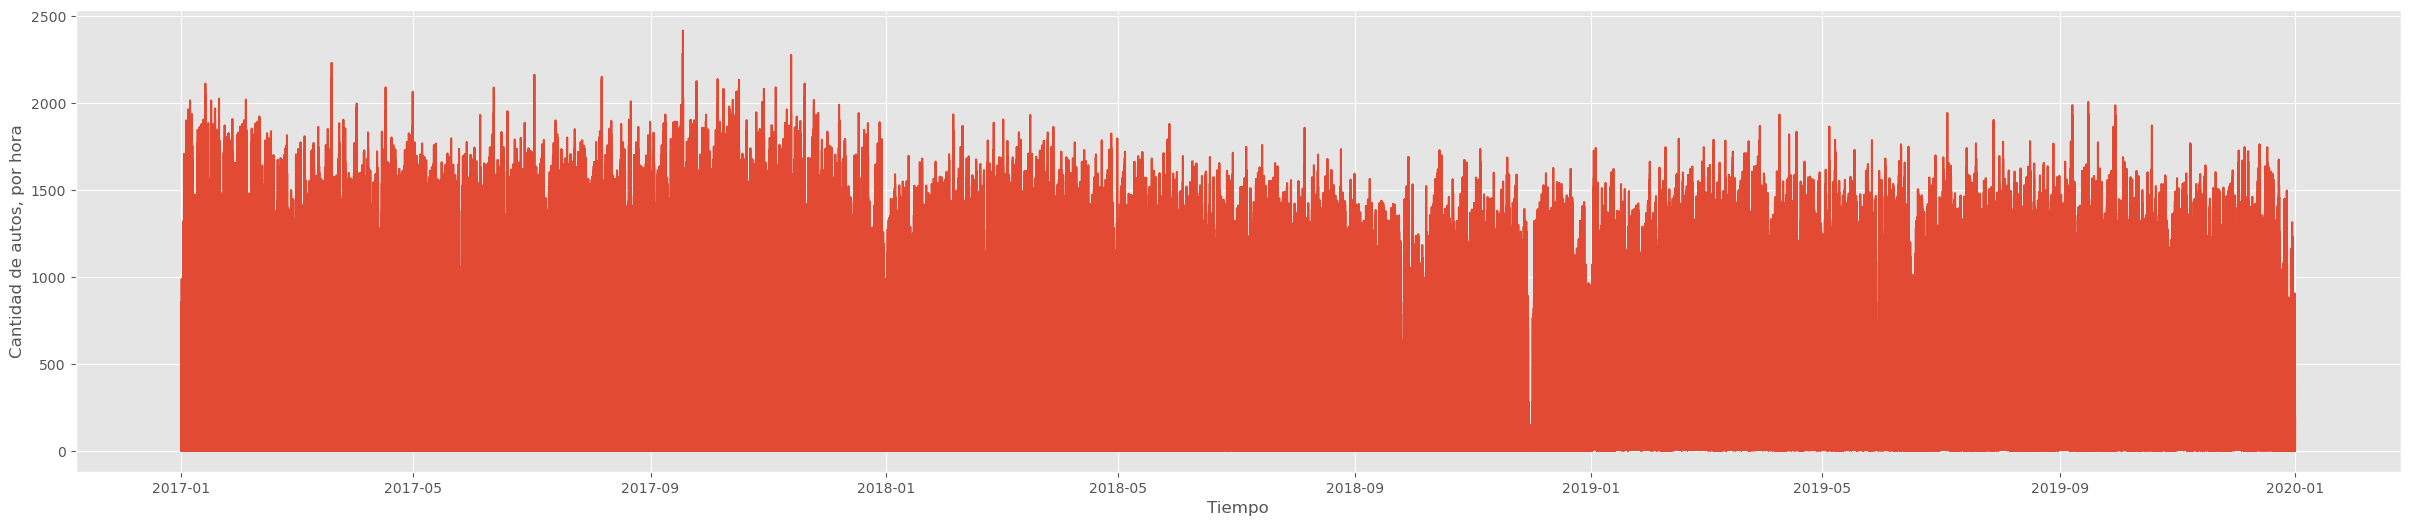

In [407]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (30,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [408]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


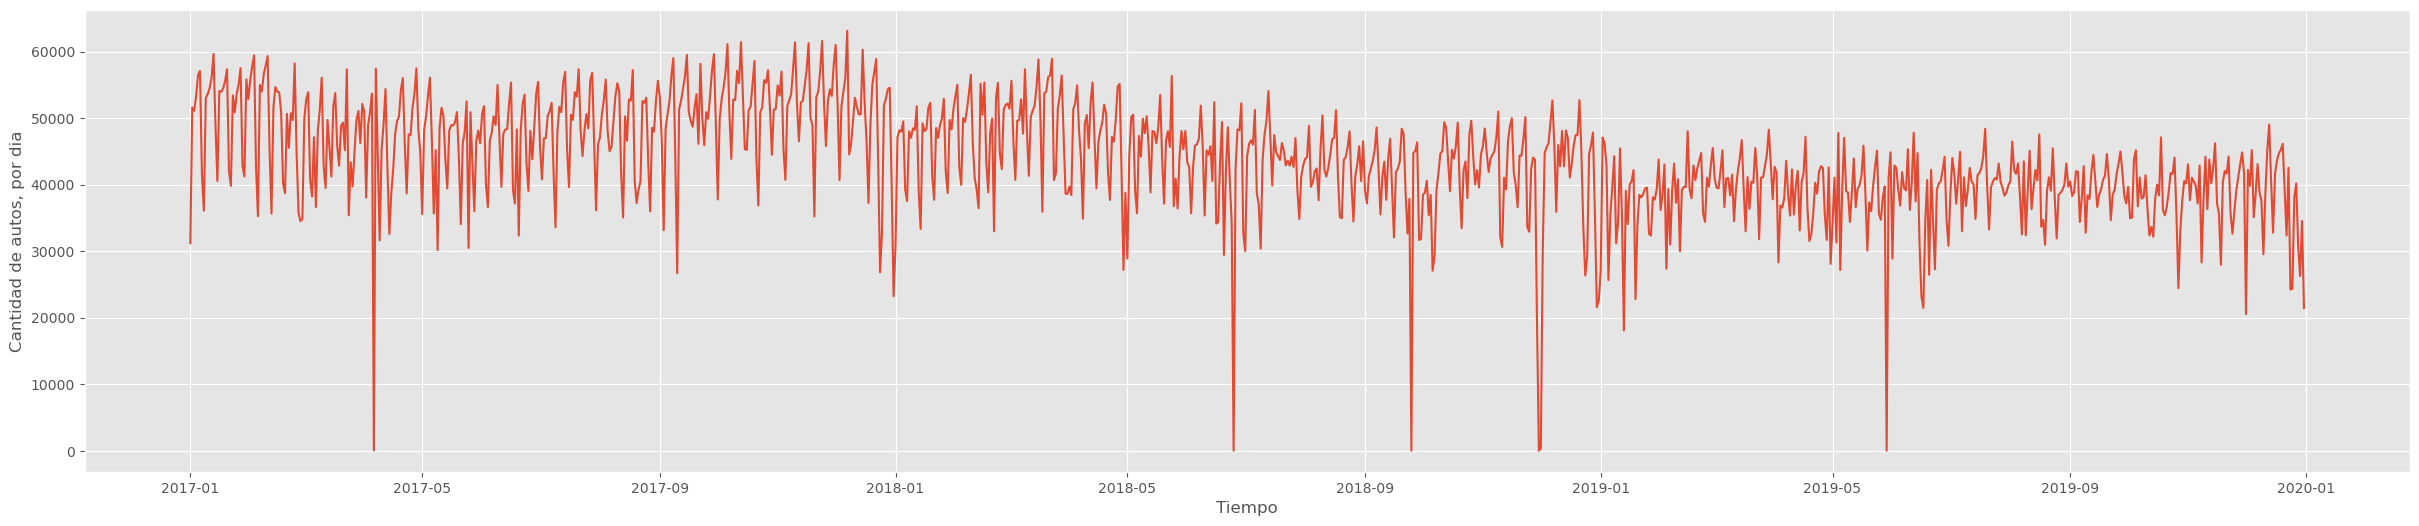

In [409]:
plt.figure(figsize = (30,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [410]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
hora = dataset.resample('H', on = 'fecha').sum()
print(hora.shape)
hora.head()

(26280, 1)


,cantidad_pasos
fecha,
2017-01-01 00:00:00,1576
2017-01-01 01:00:00,1
2017-01-01 02:00:00,1374
2017-01-01 03:00:00,1734
2017-01-01 04:00:00,1247


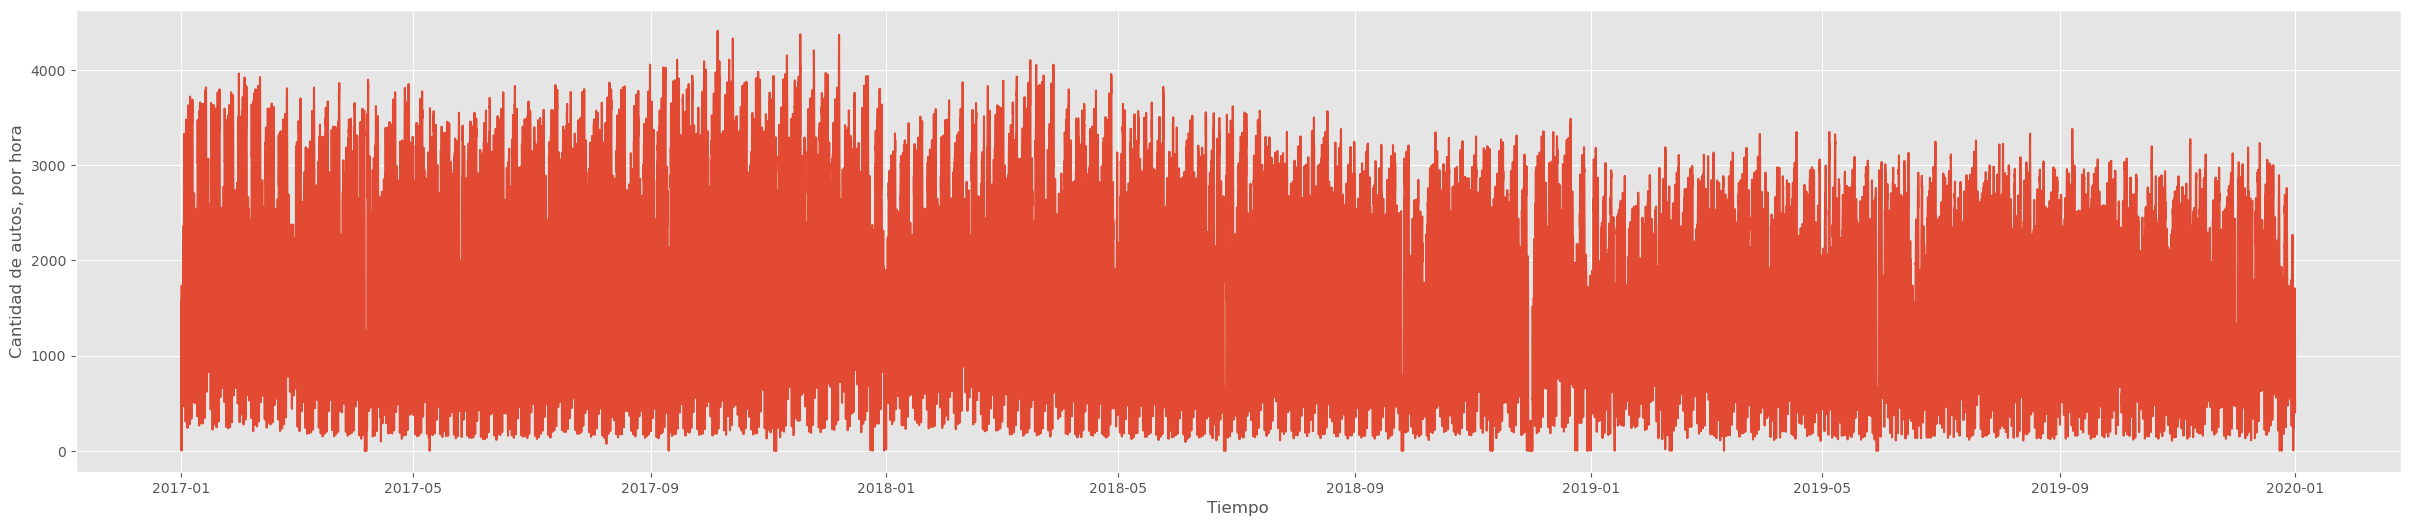

In [411]:
plt.figure(figsize = (30,6))
plt.plot(hora.index, hora.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

---

<br />
<br />

# ANÁLISIS EXPLORATORIO DE DATOS
<br />
<br />

---

## Recordemos los datasets

Se tiene 4 datasets, uno por cada año, más el dataset que agrupa los tres años filtrado por estación y por tipo depago.

In [412]:
print('Shape 2017: ', data_2017.shape)
print('Shape 2018: ', data_2018.shape)
print('Shape 2019: ', data_2019.shape)
print('Shape Total (Illia / Efectivo): ', dataset.shape)

Shape 2017:  (1372645, 10)
Shape 2018:  (1375908, 10)
Shape 2019:  (812153, 10)
Shape Total (Illia / Efectivo):  (238869, 5)


###  Dataset

**Consideremos el dataset completo para realiar el EDA**

In [413]:
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [414]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


El dataset contiene 238.869 celdas con 5 columnas. Este dataset viene de concatenar tres años de data (2017, 2018 y 2019), y de haberle aplicado filtros por estación ('Illia ) y forma de pago (efectivo). \
No está sampleado, sólo está filtrado, por lo que podemos considerar este dataset como nuestro dataset inicial para realizar la exploración. \
La información está por hora, se espera resamplear para ver tendencias por día, mes y año. \
Además no se descarta volver a utilizar la información de raíz (sin filtrar) para ver detalles de las otras columnas y su influencia sobre los modelos.

## Valores Unicos

In [415]:
unique = dataset.nunique()
unique

dia                   7
sentido               2
tipo_vehiculo         2
cantidad_pasos     1967
fecha             26102
dtype: int64

In [416]:
dataset['dia'].unique()

array(['Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes',
       'Sábado'], dtype=object)

Como es de esperarse, todos los dias de la semana están presentes

In [417]:
dataset['sentido'].unique()

array(['Provincia', 'Centro'], dtype=object)

Existen dos unicos sentidos, Provincia y Centro

In [418]:
dataset['tipo_vehiculo'].unique()

array(['Pesado', 'Liviano'], dtype=object)

Existen dos tipos de vehiculos: Liviano y Pesado


No tiene sentido revisar valores unicos de pases y fecha, ya que se esperan tener muchos valores de estos items.

## Valores Nulos

In [419]:
def null_det(df):
    df_nulo = df.isnull().sum().sort_values(ascending =False)[df.isnull().sum()>0]
    df_nulo = pd.DataFrame({'Nombre_de_columna_con_Nulos':df_nulo.index,'Cant_de_Nulos':df_nulo.values})
    df_nulo['% de Nulos'] = round(((df_nulo.Cant_de_Nulos/df.shape[0])*100),2)
    return(df_nulo)

In [420]:
null_det(dataset)

,Nombre_de_columna_con_Nulos,Cant_de_Nulos,% de Nulos


No se tienen valores nulos en el dataset.\
Vamos a revisar los dataset de cada año para descartar que se hayan habido nulos antes de hacer el concatenado:

In [421]:
null_det(data_2017)

,Nombre_de_columna_con_Nulos,Cant_de_Nulos,% de Nulos


In [422]:
null_det(data_2018)

,Nombre_de_columna_con_Nulos,Cant_de_Nulos,% de Nulos


In [423]:
null_det(data_2019)

,Nombre_de_columna_con_Nulos,Cant_de_Nulos,% de Nulos


Se observa como no hay nulos en los datasets originales por año.

## Outliers

Resampliamos por dia para analizar valores atípicos diarios, ya que por hora no tendría mucho sentido de analizar:

In [424]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [425]:
diario.describe()

,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


Text(0.5, 1.0, 'Pasos por Día')

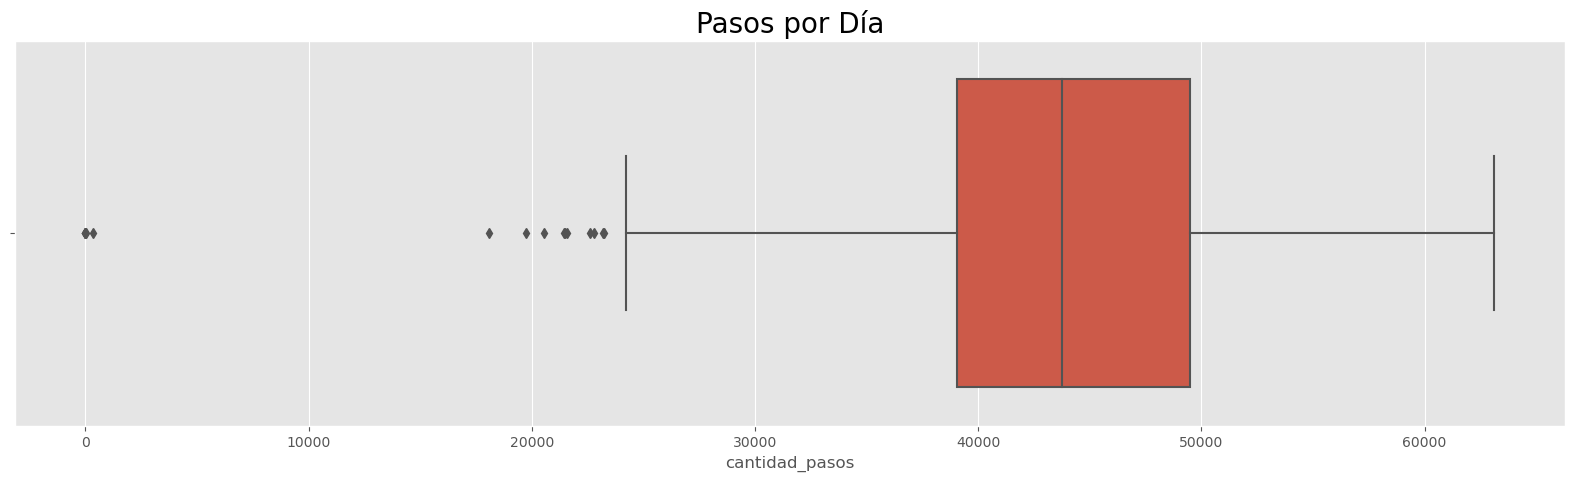

In [426]:
plt.figure(figsize=(20,5))
sns.boxplot(diario.cantidad_pasos)
plt.title("Pasos por Día", fontsize=20)

Graficamente se obervan algunos valores por debajo del outlier inferior.\
Determinemos el outlier inferior y cuanto representan estos en la data.

In [427]:
Q1 = diario['cantidad_pasos'].quantile(0.25)
Q2 = diario['cantidad_pasos'].quantile(0.50)
Q3 = diario['cantidad_pasos'].quantile(0.75)


IQR = Q3 - Q1

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
low_lim

23406.75

Se tiene como outlier inferior el valor de 23406 pasos

In [428]:
menores_que_outlier = diario.loc[diario['cantidad_pasos']<low_lim]
porcentaje_menores_que_outlier = 100*menores_que_outlier.count()/diario.count()
porcentaje_menores_que_outlier

cantidad_pasos    1.461187
dtype: float64

In [429]:
menores_que_outlier

,cantidad_pasos
fecha,
2017-04-06,40
2017-12-31,23229
2018-06-25,0
2018-09-25,0
2018-11-29,19728
2018-11-30,0
2018-12-01,350
2018-12-30,21559
2018-12-31,22599


Con la siguiente información se puede observar como los días con cero pases corresponden a eventos sociales específicos, explicando asi la naturaleza de los mismos.

* 2017-04-06: Huelga General
* 2018-06-25: Huelga General
* 2018-09-25: Huelga General
* 2018-11-30: Reunión G20
* 2018-12-01: Reunión G20 
* 2019-05-29:  Huelga General

## DataSet Diario

In [430]:
diario = diario[diario.cantidad_pasos > low_lim]
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-26,38168
2019-12-27,40182
2019-12-28,30681


Continuemos con este dataset habiendo eliminado los outliers

## Distribuciones

Para el analizis de las distribuciones tenemos que trabajar con los datasets de cada año. Esto para poder ver en mejor detalle la distribución de cada item.

Enfoquemosno en:\
-Estacion (categórica)\
-Sentido (categórica)\
-Tipo de Vehiculo (categórica)\
-Forma de Pago (categórica)
-Cantidad de Pases (numérica)

### Categóricas

In [431]:
def plot_cat(cat, y_lim):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.countplot(data_2017[cat])
    plt.title(f'Distribución de {cat} del Año 2017', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.subplot(1,3,2)
    sns.countplot(data_2018[cat])
    plt.title(f'Distribución de {cat} del Año 2018', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.subplot(1,3,3)
    sns.countplot(data_2019[cat])
    plt.title(f'Distribución de {cat} del Año 2019', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.tight_layout()

**Estación**

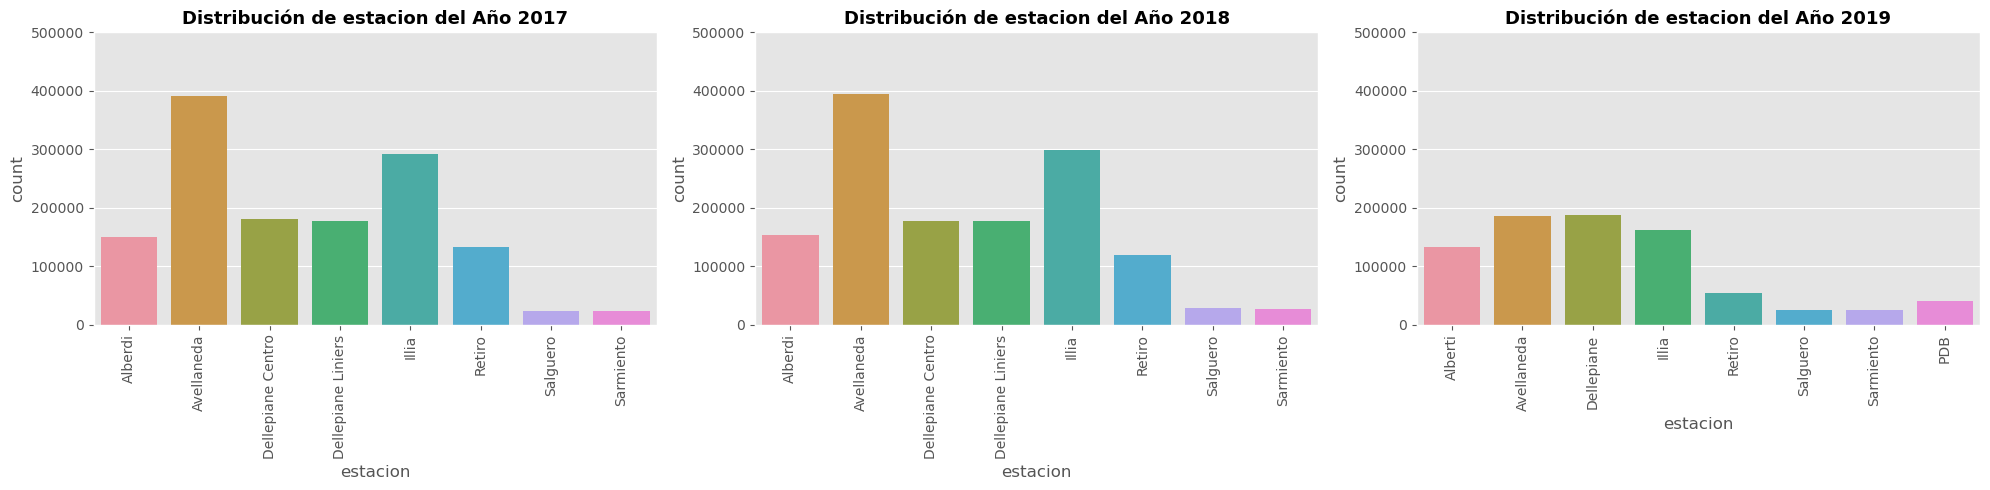

In [432]:
plot_cat('estacion', 500000)

Se observa que la más concurrida en todos los anños es Avellaneda. Siendo la Illia la segunda. Además se ven diferencias entre los dos primeros años y el 2019, donde se redducen los pases de unos 400.000 que presentaba avellaneda a unos 175.000, menos de la mitad. Probablemente al efecto pandemia.

**Sentido**

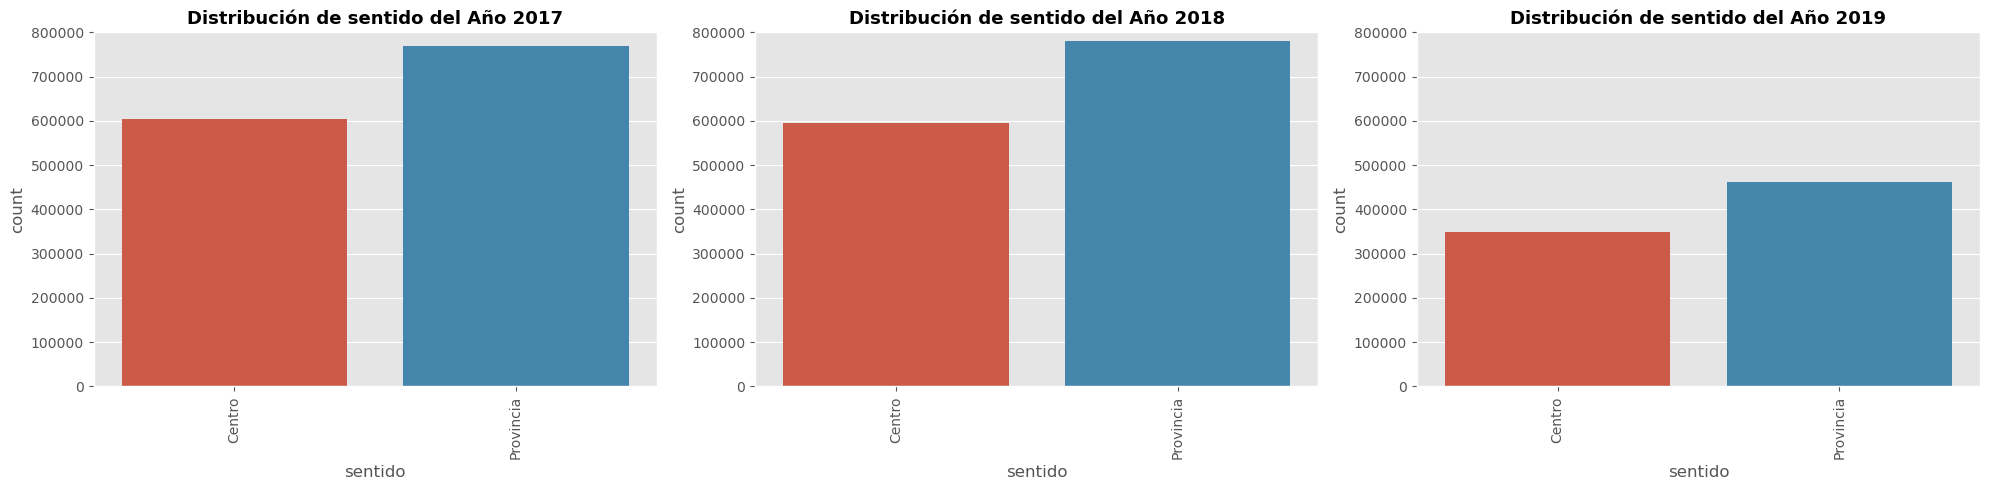

In [433]:
plot_cat('sentido', 800000)

Se observan mas pases hacia provincia que hacia centro. Y análogamente al sentido, menos pases en el año 2019.

**Tipo de Vehículo**

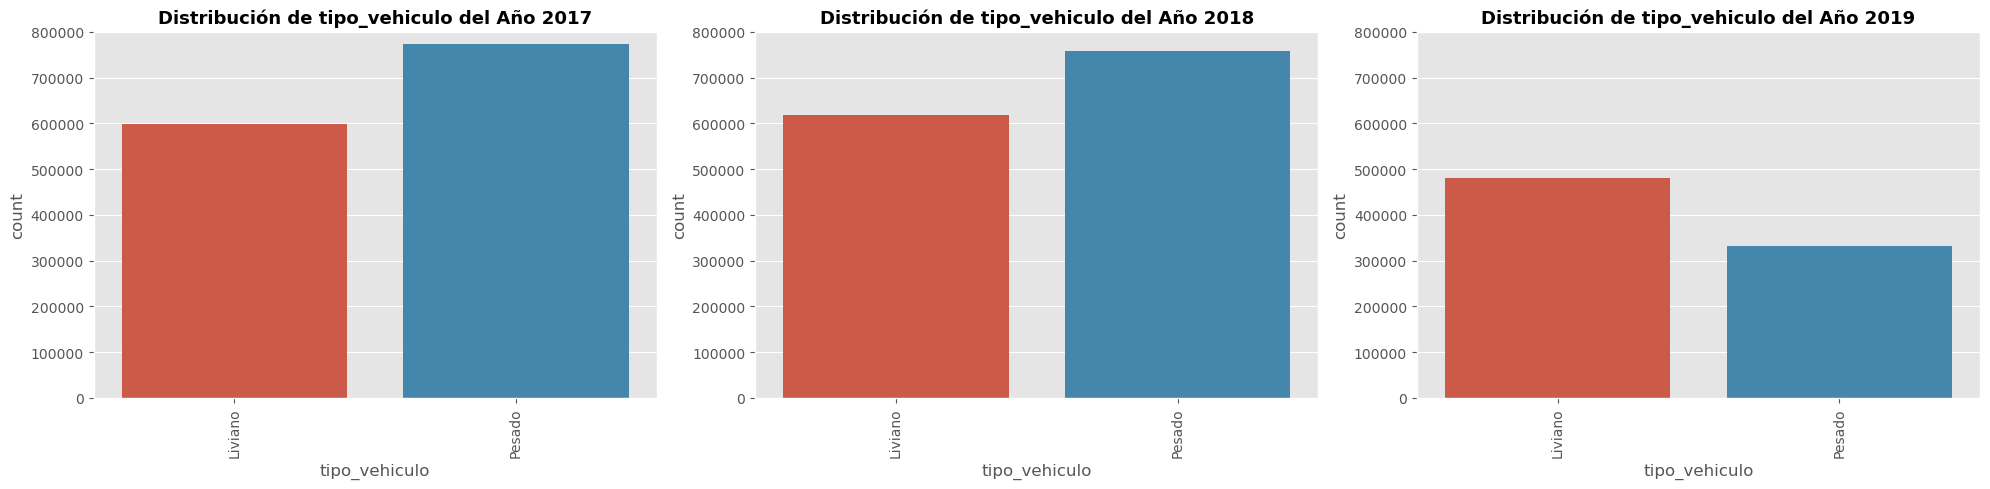

In [434]:
plot_cat('tipo_vehiculo', 800000)

Se observan más pases de vehículos pesados en los años 2017 y 2018, pero esto se invierte en el 2019. Hasta ahora se nota como el año 2019 viene presentando patrones distintos a los años anteriores, posiblemente debido a la pandemia. Esto seguro afectará de forma negativa la eficiencia de los modelos aplicados.

**Forma de Pago**

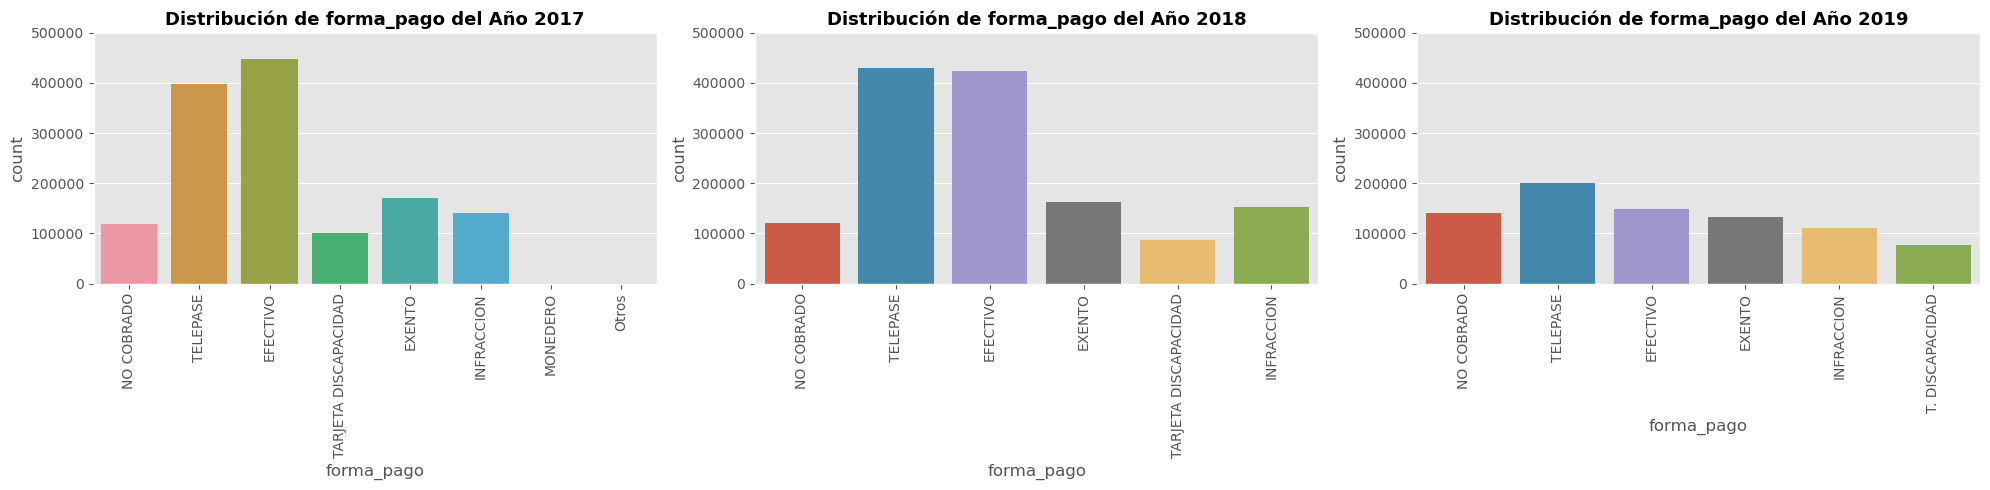

In [435]:
plot_cat('forma_pago', 500000)

La forma de pago efectivo dominaba en el 2018, pero el Telepase fue aumentando de incidencia, tal vez debido a a tendencia de usar menos efectivo y utilizar más las herramientas digitales.

### Numéricas

**Cantidad de Pasos**\
Usemos el dataset concatenado, para tener cantidad de pasos diarios

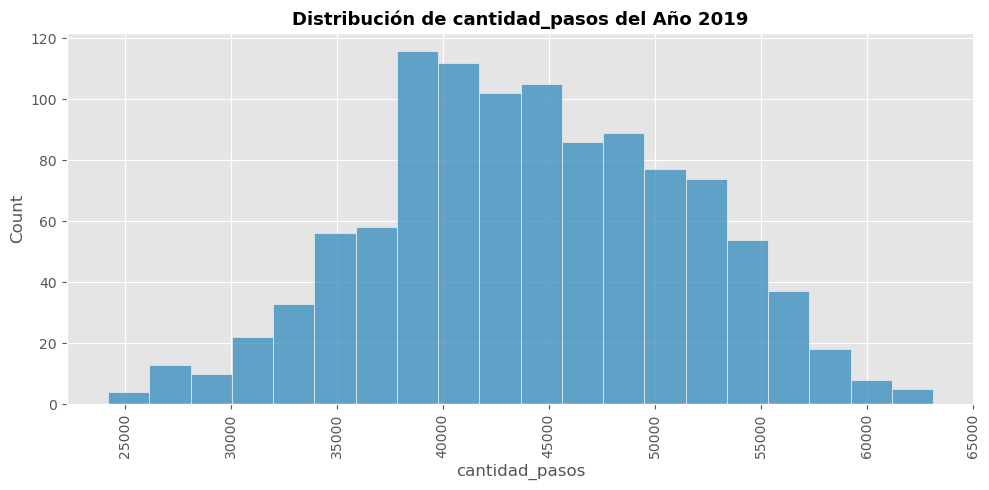

In [436]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2019', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

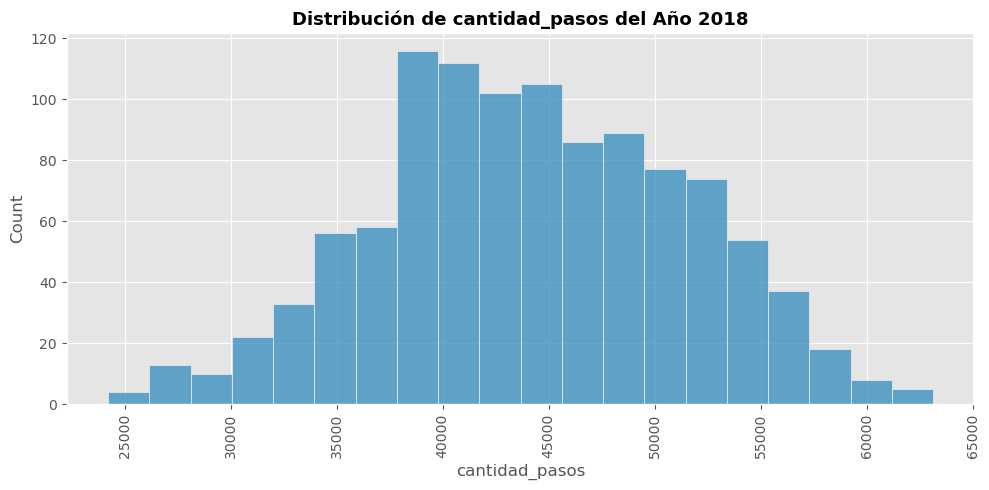

In [437]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2018', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

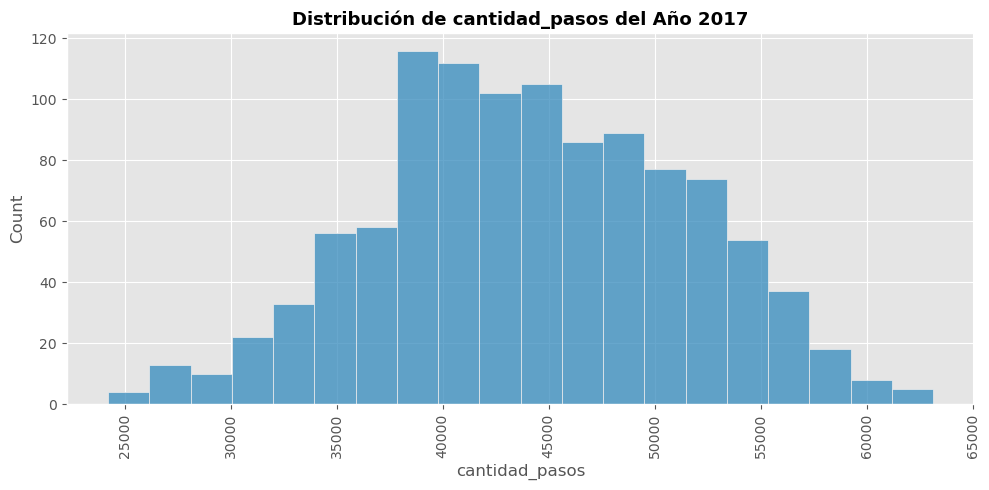

In [438]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2017', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

Se observa que la cantidad de pasos mas comunes son entre 40.000 y 50.000 por día, con distribuciones con sesgo hacia la derecha, es decir cn tendencia a mayores pasos.

## Descomposición de la serie

Echemos un vistazo a la descomposición de esta seria de tiempo. Utilizando la función Seasonal_decompose que muestra lo siguiente:\
    - Trend (Tendencia)\
    - Seasonality (Estacionalidad)\
    - Residual/Noise (Ruido)

Tomemos el dataset concatenado. Por ahora no hagamos la separación de train/test, ésta se hará en la aplicación de los modelos de machine learning.

Recordemos el dataset a utilizar:

Vamos a asumir modelo de adición y veamos los componentes:

<Figure size 1000x1000 with 0 Axes>

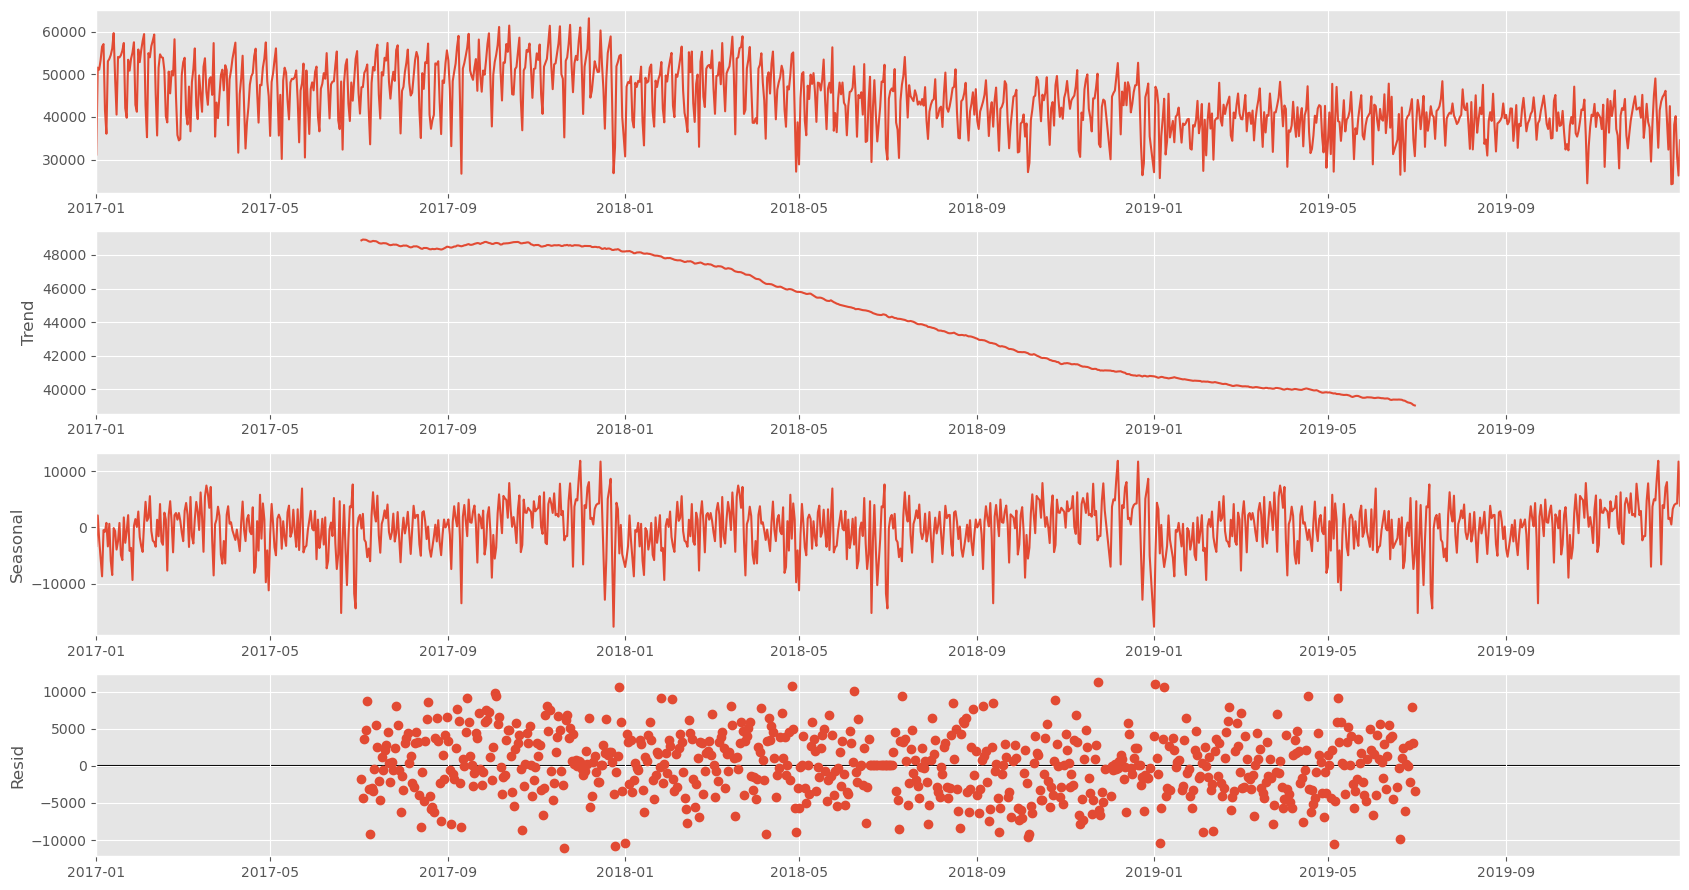

In [439]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(diario, model='additive', freq=365)
fig = result.plot()
fig.set_size_inches((17, 9))
fig.tight_layout()
plt.show()

Ahora revisemos un modelo multiplicativo:

<Figure size 1000x1000 with 0 Axes>

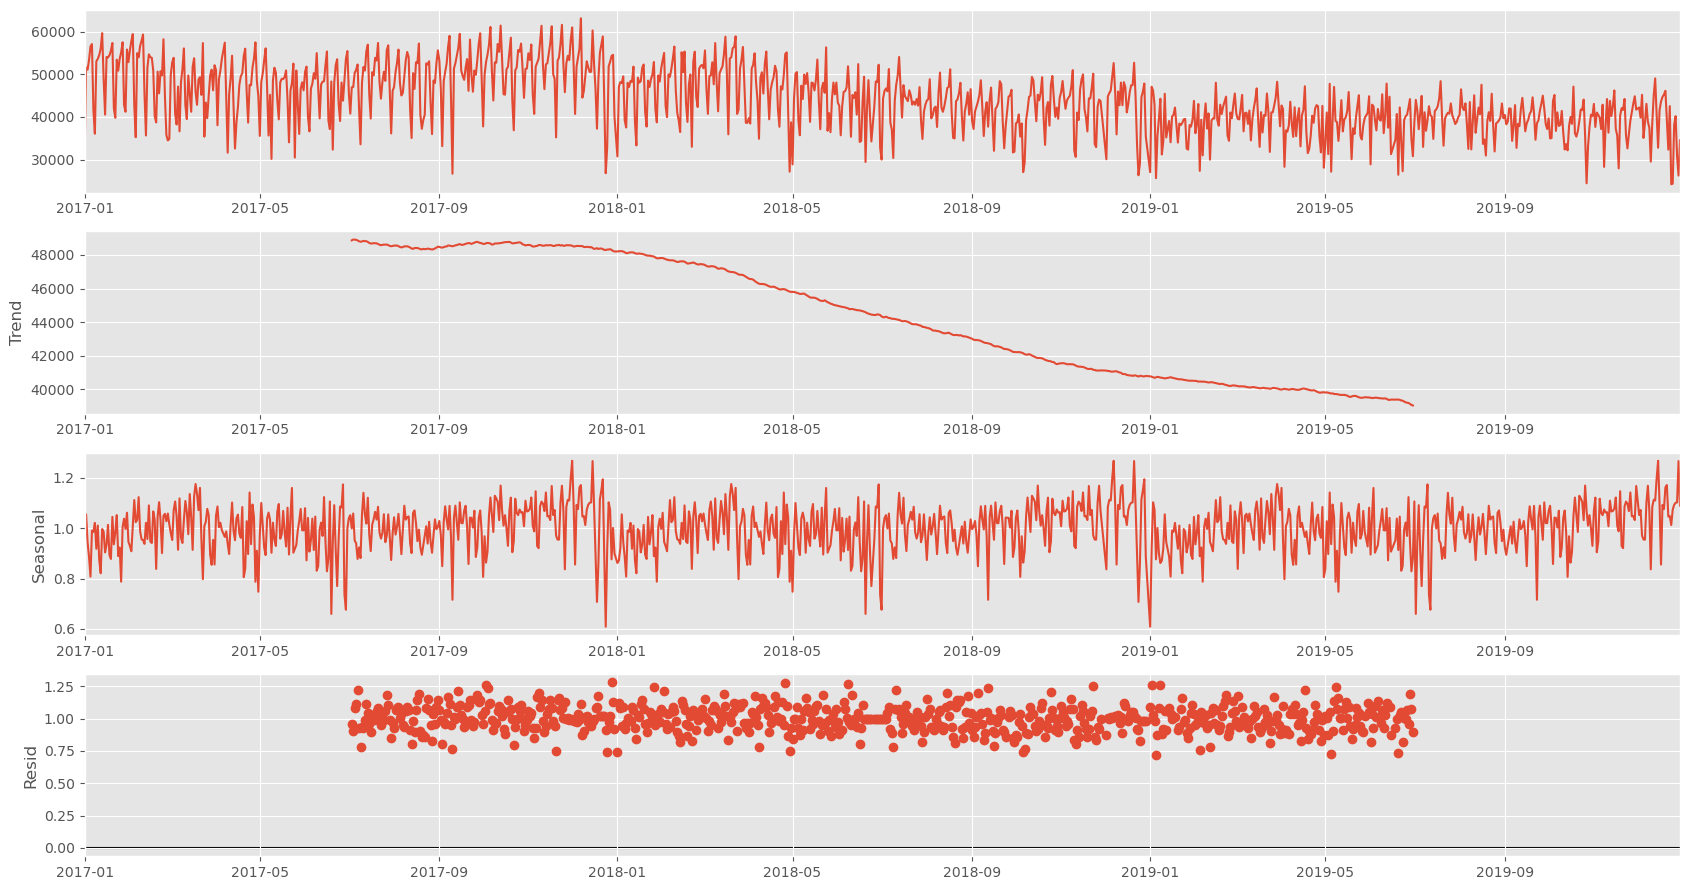

In [440]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(diario, model='multiplicative', freq=365)
fig = result.plot()
fig.set_size_inches((17, 9))
fig.tight_layout()
plt.show()

En ambos casos se oberva una tendencia a disminuir en el tiempo con cierta estabilización al inicio y al final.

Por lo general las tendencias exponenciales responden a modelos multiplicativos, y tendencias con cierta linealidad a modelos de adición, a continuación probemos un modelo de adición pero considerando frecuencia semanal: 

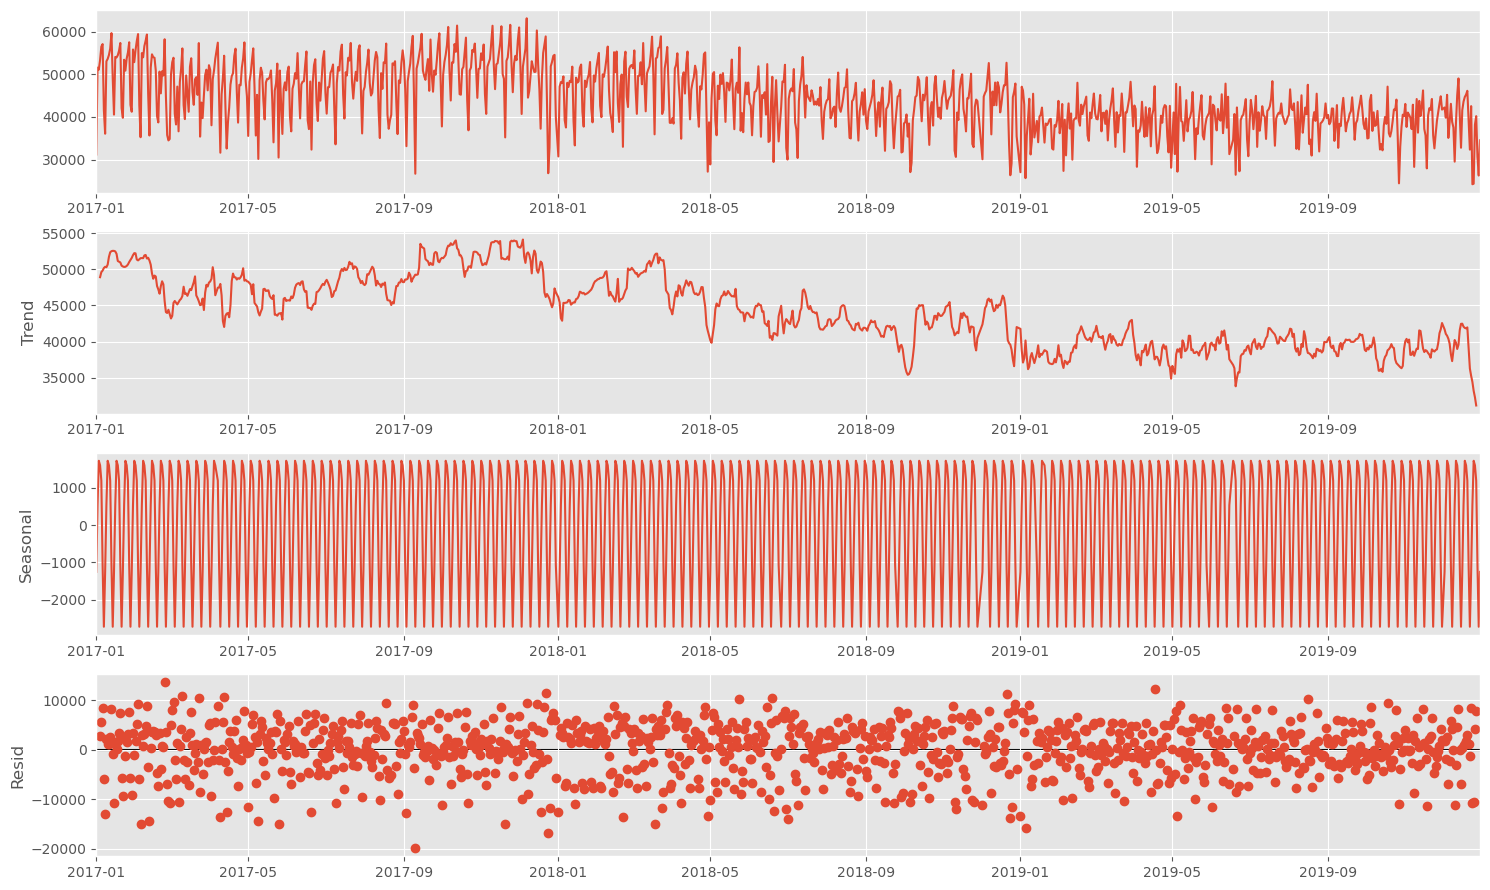

In [441]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(diario, model='additive', freq=7)
fig = result.plot()
fig.set_size_inches((15, 9))
fig.tight_layout()
plt.show()

Se observa como se muestran los ciclos que representan las semanas, lo que se espera considerando que los días deben guardar cierta relación entre cada semana.

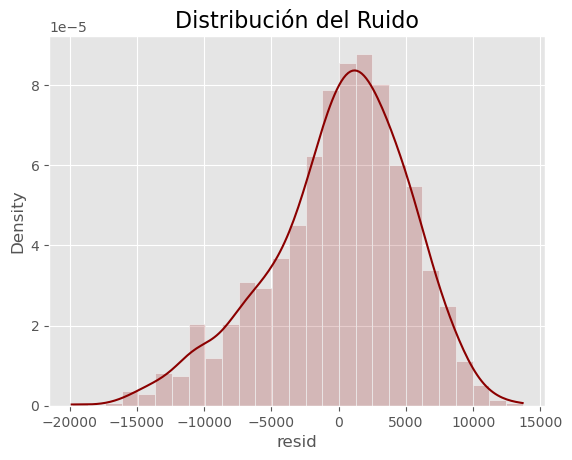

In [442]:
import statsmodels.api as sm
descomposicion_diario = sm.tsa.seasonal_decompose(diario['cantidad_pasos'], model='additive', freq=7)
residual_diario = descomposicion_diario.resid

# plt.figure(figsize = (6,4))
fig = sns.histplot(data=residual_diario, stat='density', kde=True, color='darkred', alpha=0.2)
plt.title('Distribución del Ruido', fontsize=16)
plt.show()


Se observa buena distribución de errores hacia el cero con leve sesgo a la derecha, Probablemente hayan otras estacionalidades que el modelo aditivo no está considerando.

## Prueba de ADFuller

In [443]:
result  = adfuller(diario.cantidad_pasos)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.7085053152896077
n_lags: 22
p-value: 0.42673569645357046
Critial Values:
   1%, -3.436557639266102
Critial Values:
   5%, -2.8642808573632874
Critial Values:
   10%, -2.5682293371570823


El resultado obtenido de p-value es mayor que el nivel de significancia de 0.05 y el ADF Statistic es mayor que cualquier valor critico.\
Claramente no hay razon para rechazar  la hipotesis nula. Por lo que la serie es de hecho No-Stacionaria

# MODELOS DE MACHINE LEARNING

## Separación Train/Test

Consideremos estacionalidad diaria y semanal para evaluar los modelos. A continuación, preparemos la data:

Preparando dataset diario, aseguremosno de tener una columna de fecha en numero para ser utlizada mas adelante.

In [444]:
diario = dataset[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
diario["fecha_num"] = diario.index.map(dt.datetime.toordinal)
diario.head(2).append(diario.tail(2))

,cantidad_pasos,fecha_num
fecha,,
2017-01-01,31183,736330
2017-01-02,51568,736331
2019-12-30,34523,737423
2019-12-31,21447,737424


Creamos además el dataset semanal

In [446]:
# El periodo a predecir es el ultimo trimestre del 2019, es decir desde el 1/10/2019

diario.reset_index("fecha",inplace=True)


semanal = diario.copy()
# semanal.reset_index(inplace=True)
semanal.drop(columns=['fecha_num'], inplace=True)

# semanal.reset_index('fecha', inplace=True)
diario.set_index("fecha", inplace=True)

In [447]:
semanal = semanal[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
semanal["fecha_num"] = semanal.index.map(dt.datetime.toordinal)
semanal.head(3).append(semanal.tail(3))

,cantidad_pasos,fecha_num
fecha,,
2017-01-01,31183,736330
2017-01-08,347212,736337
2017-01-15,366413,736344
2019-12-22,292881,737415
2019-12-29,226390,737422
2020-01-05,55970,737429


In [448]:
semanal.drop(semanal.tail(1).index,inplace=True)
semanal.drop(semanal.head(1).index,inplace=True)
semanal.head(3).append(semanal.tail(3))

,cantidad_pasos,fecha_num
fecha,,
2017-01-08,347212,736337
2017-01-15,366413,736344
2017-01-22,357215,736351
2019-12-15,272960,737408
2019-12-22,292881,737415
2019-12-29,226390,737422


Separamos los últimos tres meses para dejarlos como test:

In [449]:
diario.reset_index("fecha",inplace=True)
semanal.reset_index("fecha",inplace=True)

train_diario = diario.loc[(diario['fecha'] < '2019-10-01')]
test_diario = diario.loc[(diario['fecha'] >= '2019-10-01')]

train_semanal = semanal.loc[(semanal['fecha'] < '2019-10-01')]
test_semanal = semanal.loc[(semanal['fecha'] >= '2019-10-01')]

diario.set_index("fecha", inplace=True)
train_diario.set_index("fecha", inplace=True)
test_diario.set_index("fecha", inplace=True)


semanal.set_index("fecha", inplace=True)
train_semanal.set_index("fecha", inplace=True)
test_semanal.set_index("fecha", inplace=True)

In [450]:
train_diario

,cantidad_pasos,fecha_num
fecha,,
2017-01-01,31183,736330
2017-01-02,51568,736331
2017-01-03,51093,736332
2017-01-04,53332,736333
2017-01-05,56486,736334
...,...,...
2019-09-26,43110,737328
2019-09-27,44985,737329
2019-09-28,41925,737330


In [451]:
test_diario

,cantidad_pasos,fecha_num
fecha,,
2019-10-01,39669,737333
2019-10-02,34943,737334
2019-10-03,35054,737335
2019-10-04,43775,737336
2019-10-05,45150,737337
...,...,...
2019-12-27,40182,737420
2019-12-28,30681,737421
2019-12-29,26259,737422


In [452]:
train_semanal

,cantidad_pasos,fecha_num
fecha,,
2017-01-08,347212,736337
2017-01-15,366413,736344
2017-01-22,357215,736351
2017-01-29,354581,736358
2017-02-05,359401,736365
...,...,...
2019-09-01,279775,737303
2019-09-08,276271,737310
2019-09-15,272592,737317


In [453]:
test_semanal

,cantidad_pasos,fecha_num
fecha,,
2019-10-06,272483,737338
2019-10-13,260840,737345
2019-10-20,267147,737352
2019-10-27,262950,737359
2019-11-03,273129,737366
2019-11-10,270536,737373
2019-11-17,281790,737380
2019-11-24,264500,737387
2019-12-01,266555,737394


## Arima (Benchmark)

Antes de inciar a trabajar en los modelos de Machine Learning, definamos un par de funciones que nos ayudarán al dedsarrollo de los mismos:

In [288]:
def evaluar_modelo(y_pred, y_true, model):

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    dataf = pd.DataFrame({
        "Modelo": model,
        "RMSE":[RMSE]
    })
    return dataf

def plot_modelo(train,test,pred) :
    fig, (ax1,ax2) = plt.subplots(2,figsize=(18,8))

    ax1.plot(train, label='Train')
    ax1.plot(test , label='Test')
    ax1.plot(pred, label='Forecast')
    ax1.legend(loc="upper right")
    ax1.grid(axis = "both")
    ax2.plot(test, label='Test')
    ax2.plot(pred, label='Forecast')
    ax2.legend(loc="upper right")

    fig.suptitle("Train - Test - Forecast", fontsize=20)
    ax2.grid(axis = "both")

Apliquemos factor de diferenciación:

In [289]:
diario_est = diario.diff(periods=1)
diario_est = diario_est[1:]
diario_est.head()

,cantidad_pasos,fecha_num
fecha,,
2017-01-02,20385.0,1.0
2017-01-03,-475.0,1.0
2017-01-04,2239.0,1.0
2017-01-05,3154.0,1.0
2017-01-06,595.0,1.0


Veamos cada uno de los elementos del modelo Arima

### Auto Correlation (AR)

<Figure size 1800x600 with 0 Axes>

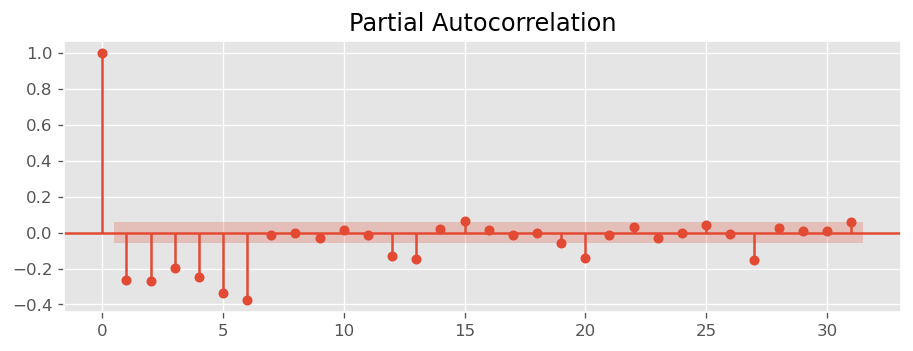

In [290]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.figure(figsize = (15,5))
plot_pacf(diario_est.cantidad_pasos)
plt.show()

De a acuerdo a la gráfica p=6

### Moving Average Model

<Figure size 1800x600 with 0 Axes>

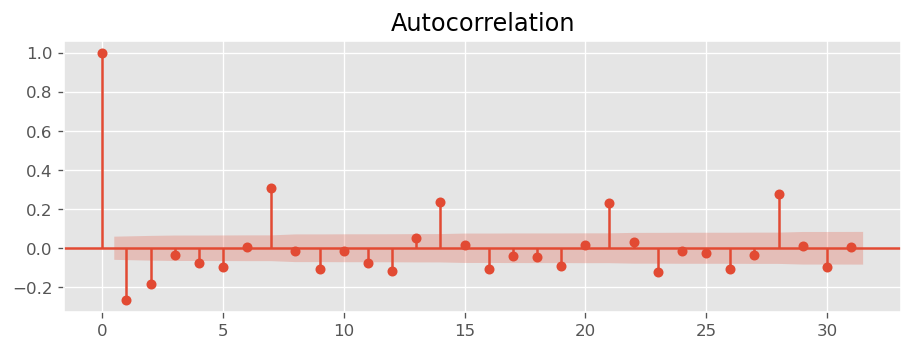

In [291]:
plt.figure(figsize = (15,5))
plot_acf(diario_est.cantidad_pasos)
plt.show()

De a acuerdo a la gráfica q=2

In [292]:
model_arima = sm.tsa.arima.ARIMA(diario.cantidad_pasos, order=(6,1,2))
# statsmodels.tsa.arima_model
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -11128.567
Date:                Sun, 29 May 2022   AIC                          22275.133
Time:                        12:36:42   BIC                          22320.112
Sample:                    01-01-2017   HQIC                         22292.153
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5889      0.100     -5.864      0.000      -0.786      -0.392
ar.L2         -0.6201      0.049    -12.669      0.000      -0.716      -0.524
ar.L3         -0.5670      0.041    -13.995      0.0

Los valores de p son mayores a 0.05, lo cual habla de su poca relevancia para el modelo

In [293]:
# ARIMA(p,d,q)
model_arima = ARIMA(diario.cantidad_pasos, order=(6,1,0))
model_arima_fit = model_arima.fit( )
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -11129.420
Date:                Sun, 29 May 2022   AIC                          22272.839
Time:                        12:36:52   BIC                          22307.823
Sample:                    01-01-2017   HQIC                         22286.077
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6464      0.016    -40.853      0.000      -0.677      -0.615
ar.L2         -0.6762      0.024    -28.171      0.000      -0.723      -0.629
ar.L3         -0.6079      0.024    -25.208      0.0

En este caso el IAC de 22272.839 es levemente menor que e modelo anterior (22275.133), por lo que tomamos este modelo como Benchmark.

**Ajustamos Benchmark con train**

In [294]:
model_benchmark = ARIMA(train.cantidad_pasos, order=(6,1,2))
model_benchmark_fit = model_benchmark.fit()##disp=0)
fc = model_benchmark_fit.forecast(61)##, alpha=0.05)
# statsmodels.tsa.arima.model.ARIMAResults.forecast

**Evaluamos sobre test**

In [454]:
res_bench =  evaluar_modelo(fc, test.cantidad_pasos, "Benchmark(diario)")
res_bench

,Modelo,RMSE
0,Benchmark(diario),5948.594624


Tomemos este valor de RMSE como punto de partida: 5948 pasos diarios

In [299]:
# predicciones_diario = pd.Series(data=fc)
# predicciones_diario

In [168]:
# test

In [298]:
# plot_modelo(train.cantidad_pasos, test.cantidad_pasos, predicciones_diario)

## AutoArima

### Auto Arima (Diario)

In [301]:
modelAA_diario = auto_arima(diario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22402.289, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22826.598, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22755.192, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22492.342, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22824.599, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22404.037, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22387.337, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22385.356, Time=0.73 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22388.283, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22385.084, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22491.200, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22387.065, Time=0.51 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=22387.955, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]  

In [302]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7]
modelAA_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AA_diario = modelAA_diario.predict(n_periods=92, return_conf_int=False)
predicciones_AA_diario = pd.Series(data=pred_AA_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AA_diario.head()

In [303]:
autoarima_diario_res = evaluar_modelo(predicciones_AA_diario, test_diario.cantidad_pasos, "AutoArima-S Diario")
autoarima_diario_res

,Modelo,RMSE
0,AutoArima-S Diario,5587.785872


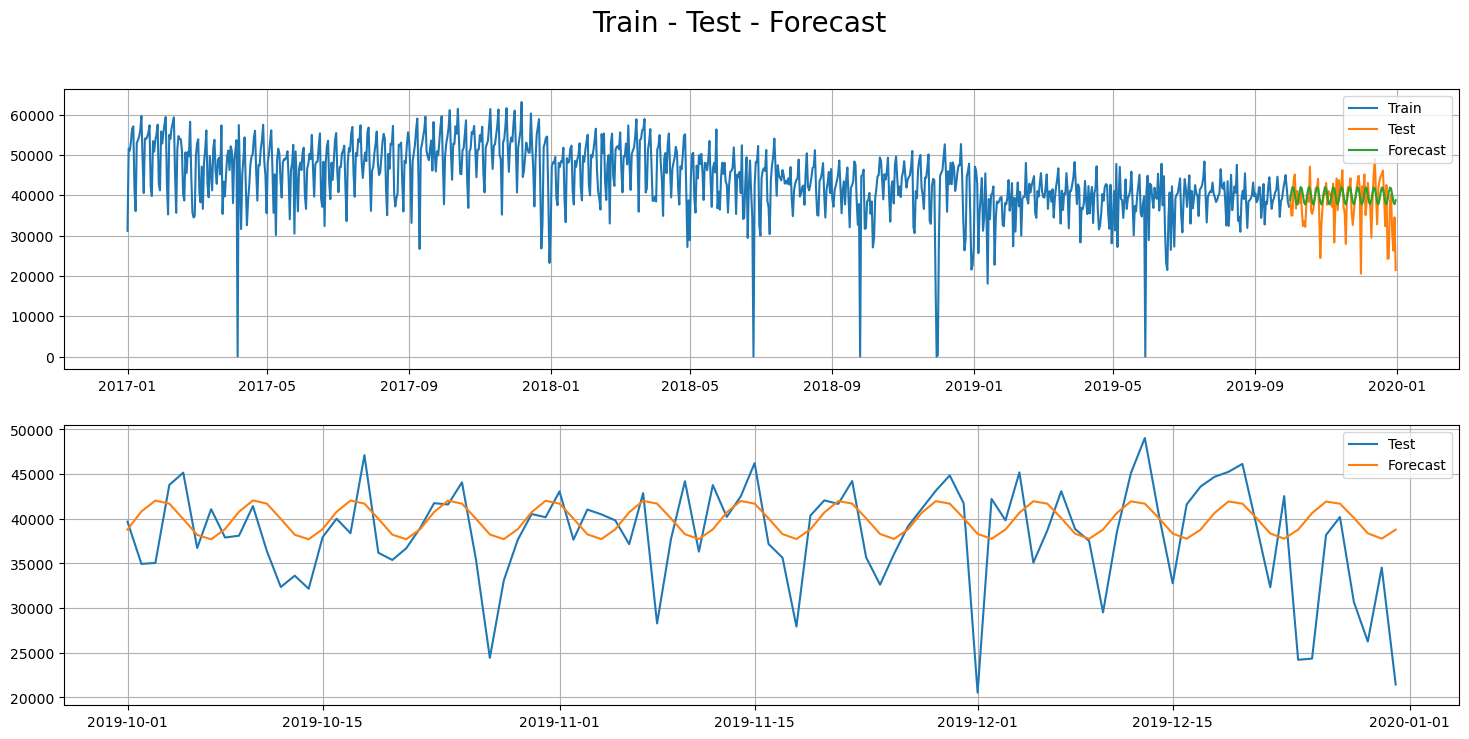

In [306]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AA_diario)

### Sarimax (Diario)

Agreguemos temporalidad diaria para evaluar el autoarima

In [308]:
modelAS_diario = auto_arima(diario.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=7, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=22530.726, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=22300.651, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=22062.382, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=22529.005, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=22487.675, Time=0.20 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=22123.762, Time=1.20 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=22131.719, Time=0.92 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=22322.768, Time=0.37 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=22132.703, Time=1.50 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=22194.839, Time=1.03 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=22039.866, Time=2.28 sec
 ARIMA(0,0,2)(0,1,0)[7] intercept   : AIC=22489.650, Time=0.21 sec
 ARIMA(0,0,2)(1,1,1)[7] intercept   : AIC=22026.802, Time=2.70 sec
 ARIMA(0,0,2)(1,1,0)[7] i

In [309]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7] 
# SARIMAX(0, 0, 2)x(1, 1, [1], 7)
modelAS_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_diario = modelAS_diario.predict(n_periods=92)
predicciones_AS_diario = pd.Series(data=pred_AS_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [310]:
autosarimax_diario_res = evaluar_modelo(predicciones_AS_diario, test_diario.cantidad_pasos, "AutoSarimax Diario")
autosarimax_diario_res

,Modelo,RMSE
0,AutoSarimax Diario,5177.831372


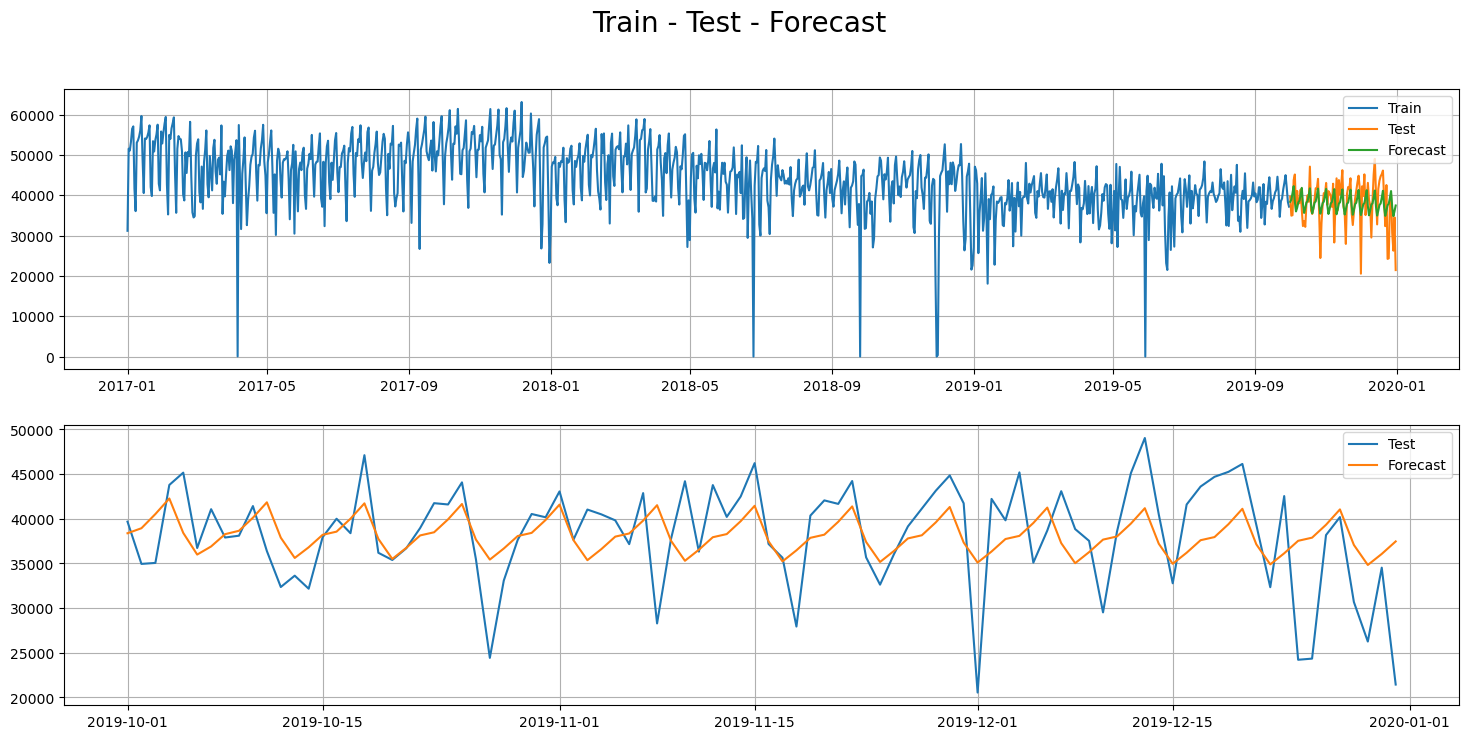

In [311]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AS_diario)

<AxesSubplot:ylabel='Count'>

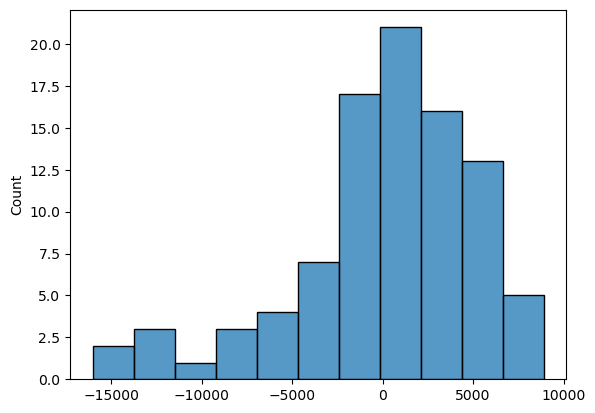

In [312]:
sns.histplot(data = test_diario.cantidad_pasos - predicciones_AS_diario, 
                 label = "Error")

### AutoArima (Semanal)

In [313]:
modelAA_semanal = auto_arima(semanal.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3576.640, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3576.907, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3574.768, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3575.557, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3575.067, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3575.028, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3577.699, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3572.761, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3572.836, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3570.360, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3573.225, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3572.432, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3573.359, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3573.802, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [314]:
# Best model:  ARIMA(1,1,0)(0,0,0)[0] 

modelAA_semanal.fit(train_semanal.cantidad_pasos)
# train_semanal.set_index('fecha', inplace=True)
# test_semanal.set_index('fecha', inplace=True)
pred_AA_semanal = modelAA_semanal.predict(n_periods=13, return_conf_int=False)
predicciones_AA_semanal = pd.Series(data=pred_AA_semanal, index=test_semanal.cantidad_pasos.index)
predicciones_AA_semanal.head()

fecha
2019-10-06    285396.962990
2019-10-13    283990.055825
2019-10-20    283078.331262
2019-10-27    282487.502173
2019-11-03    282104.624463
dtype: float64

In [315]:
autoarima_semanal_res = evaluar_modelo(predicciones_AA_semanal, test_semanal.cantidad_pasos, "AutoArima Semanal")
autoarima_semanal_res

,Modelo,RMSE
0,AutoArima Semanal,20185.213058


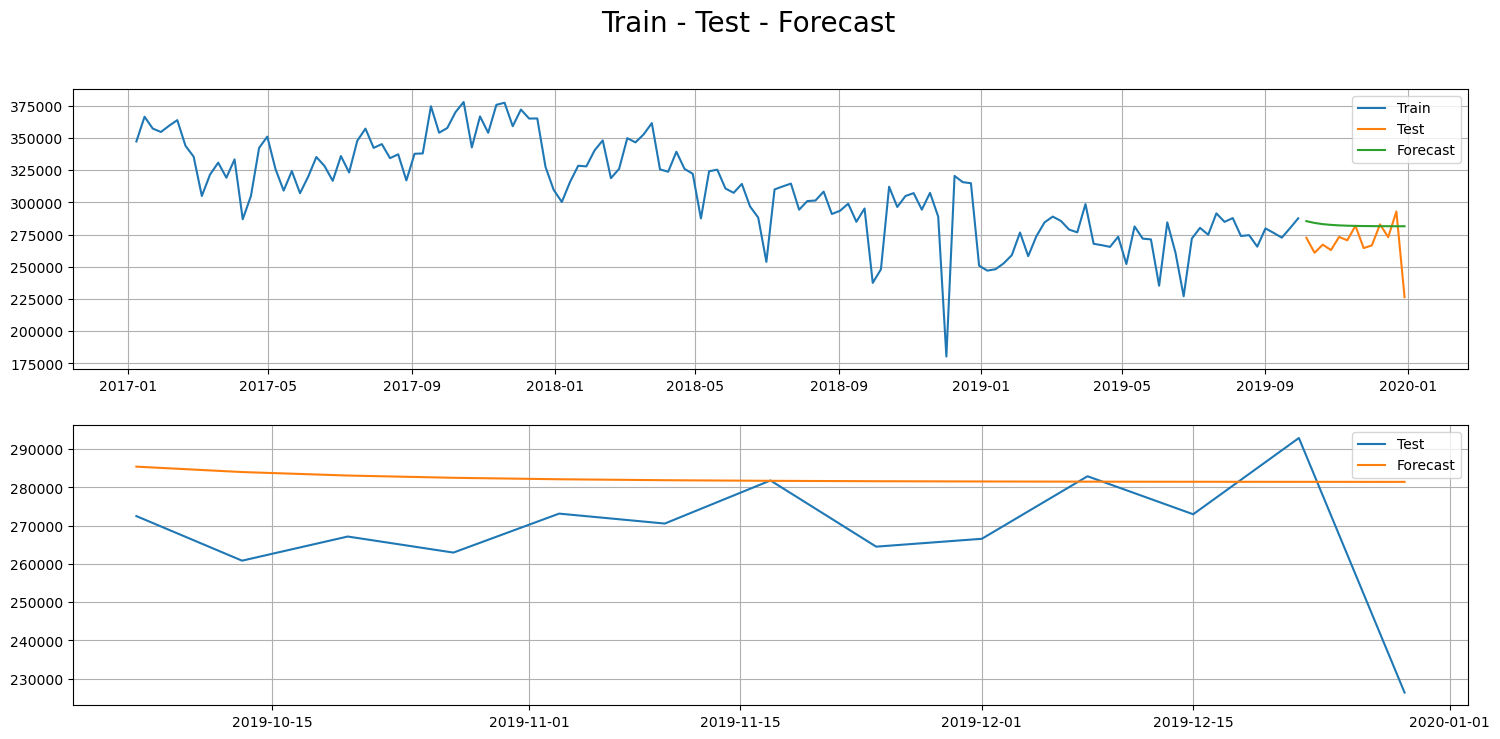

In [316]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AA_semanal)

### Sarimax (Semanal)

In [317]:
modelAS_semanal = auto_arima(diario.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=12, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=23051.398, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=22719.144, Time=0.92 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=23049.809, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=22968.861, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=22594.448, Time=2.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=22407.785, Time=3.91 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=13.99 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=22450.689, Time=13.51 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=22647.647, Time=2.16 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   :

In [319]:
# Best model:  ARIMA(4,0,0)(2,1,2)[12]
# SARIMAX(4, 0, 0)x(2, 1, [1, 2], 12)
modelAS_semanal.fit(train_semanal.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_semanal = modelAS_semanal.predict(n_periods=13)
predicciones_AS_semanal = pd.Series(data=pred_AS_semanal, index=test_semanal.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [320]:
autosarimax_semanal_res = evaluar_modelo(predicciones_AS_semanal, test_semanal.cantidad_pasos, "AutoSarimax semanal")
autosarimax_semanal_res

,Modelo,RMSE
0,AutoSarimax semanal,18428.50639


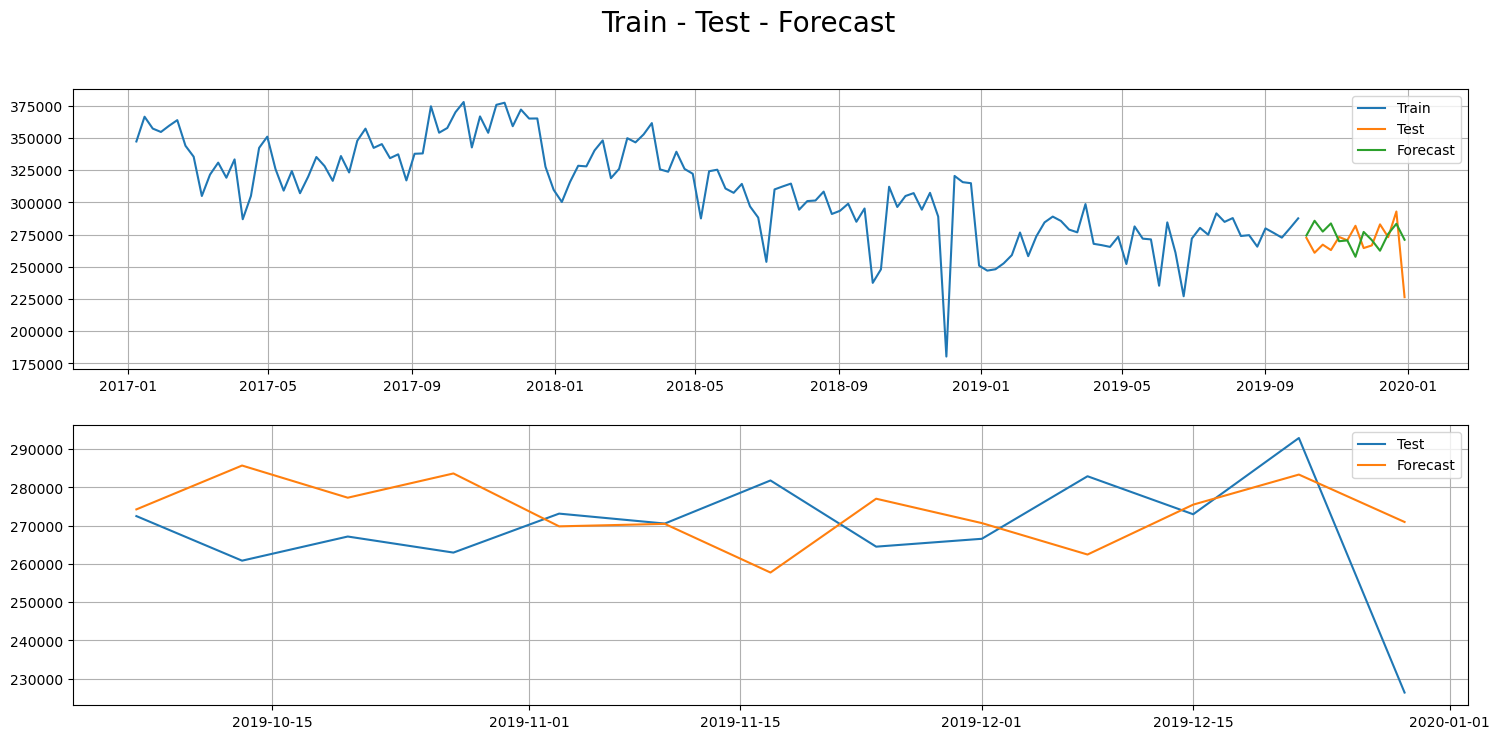

In [321]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AS_semanal)

In [322]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        autoarima_semanal_res, autosarimax_semanal_res
                         ])
# res_finales.reset_index(drop=True)

,Modelo,RMSE
0,Benchmark(diario),5948.594624
0,AutoArima-S Diario,5587.785872
0,AutoSarimax Diario,5177.831372
0,AutoArima Semanal,20185.213058
0,AutoSarimax semanal,18428.506390


## Prophet

### Prophet Diario

In [323]:
diario.reset_index("fecha",inplace=True)



prophet_diario = pd.DataFrame({'ds':diario.fecha, 'y':diario.cantidad_pasos})


diario.set_index("fecha", inplace=True)


In [324]:
separacion = '2019-10-01'
prophet_fore = prophet_diario.loc[prophet_diario.ds < separacion]
prophet_fore

,ds,y
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486
...,...,...
998,2019-09-26,43110
999,2019-09-27,44985
1000,2019-09-28,41925
1001,2019-09-29,38348


In [325]:
diario_datos_test = prophet_diario.loc[prophet_diario.ds >= separacion]
diario_datos_test

,ds,y
1003,2019-10-01,39669
1004,2019-10-02,34943
1005,2019-10-03,35054
1006,2019-10-04,43775
1007,2019-10-05,45150
...,...,...
1090,2019-12-27,40182
1091,2019-12-28,30681
1092,2019-12-29,26259
1093,2019-12-30,34523


In [326]:
prophet_diario_model = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=92, freq="D")
forecast = prophet_diario_model.predict(pred_prophet)

In [327]:
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1092,2019-12-29,11089.297179,22430.568571,41692.292698,5307.508645,17047.755880,20320.086628,20320.086628,20320.086628,29217.981986,...,-7039.315038,-7039.315038,-7039.315038,-1858.580320,-1858.580320,-1858.580320,0.0,0.0,0.0,31409.383808
1093,2019-12-30,11093.041300,27758.947162,46789.625705,5223.449322,17197.626095,25863.432969,25863.432969,25863.432969,29217.981986,...,-1112.543987,-1112.543987,-1112.543987,-2242.005030,-2242.005030,-2242.005030,0.0,0.0,0.0,36956.474269
1094,2019-12-31,11096.785421,28841.751269,47466.279862,5110.172782,17328.465956,26790.685617,26790.685617,26790.685617,29217.981986,...,174.389078,174.389078,174.389078,-2601.685447,-2601.685447,-2601.685447,0.0,0.0,0.0,37887.471038


Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1200x300 with 0 Axes>

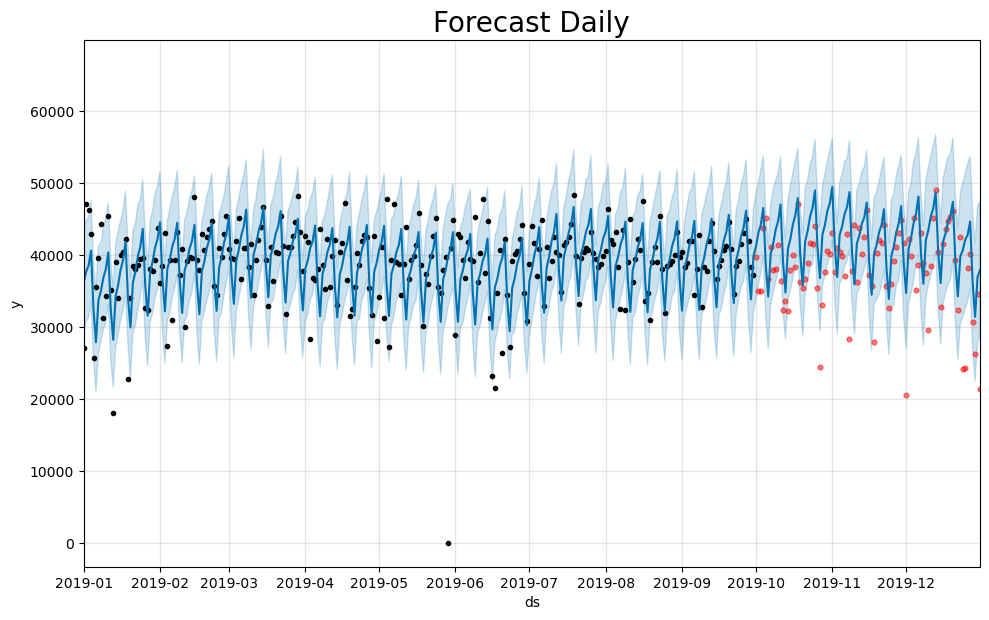

In [328]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [329]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds <= "2019-12-31")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")
res_prophet_diario

,Modelo,RMSE
0,Prophet Diario,6372.959142


### Optimizando

In [335]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    # 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
    'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


}



# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=True).fit(prophet_fore)  # Fit model with given params
    df_cv = cross_validation(m, horizon='92 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A23D5B0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B32362D820>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A2441C0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor obje

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A2062E0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A1A8730>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A2062E0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <c

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                    0.001  12521.383037
1                     0.001                    0.005  10802.237494
2                     0.001                    0.010  10449.109630
3                     0.001                    0.050  12840.329210
4                     0.001                    0.100  11571.048271
5                     0.001                    0.500  11724.959146
6                     0.001                    1.000  12122.630062
7                     0.001                    5.000  14191.806773
8                     0.001                   10.000  14139.080071
9                     0.010                    0.001   7584.943292
10                    0.010                    0.005   7153.132738
11                    0.010                    0.010   7402.072898
12                    0.010                    0.050   7835.846245
13                    0.010                    0.100   7783.37

In [337]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005}


In [338]:
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.03}
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}

In [339]:
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020}

In [340]:
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_fore)
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=92)
forecast = prophet_diario_model_op.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1200x300 with 0 Axes>

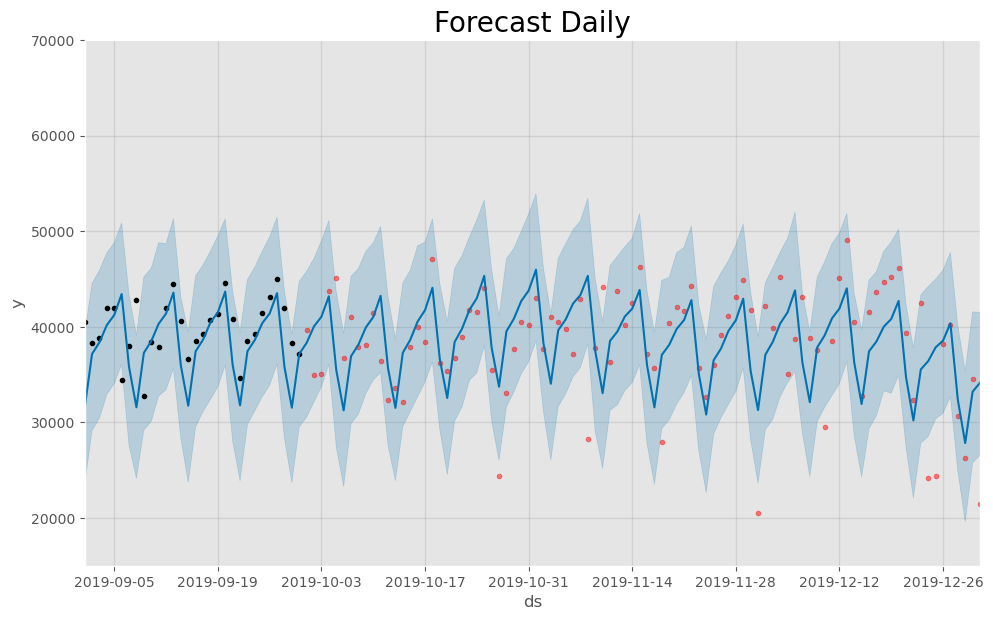

In [341]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model_op.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-09-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(15000, 70000)
plt.title('Forecast Daily', fontsize=20)

In [343]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_datos_test[['ds', 'y']]

,Modelo,RMSE
0,Prophet Diario CV/HP,5050.215638


#### Mejor Prophet

In [456]:
res_prophet_diario_opt = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario CV/HP")
res_prophet_diario_opt

,Modelo,RMSE
0,Prophet Diario CV/HP,5050.215638


### Prophet Semanal

In [344]:
semanal.reset_index("fecha",inplace=True)

prophet_semanal = pd.DataFrame({'ds':semanal.fecha, 'y':semanal.cantidad_pasos})

semanal.set_index("fecha", inplace=True)

In [345]:
separacion = '2019-10-01'
prophet_fore_semanal = prophet_semanal.loc[prophet_semanal.ds < separacion]
prophet_fore_semanal

semanal_datos_test = prophet_semanal.loc[prophet_semanal.ds >= separacion]
len(semanal_datos_test)

13

In [346]:
semanal_datos_test

,ds,y
143,2019-10-06,272483
144,2019-10-13,260840
145,2019-10-20,267147
146,2019-10-27,262950
147,2019-11-03,273129
148,2019-11-10,270536
149,2019-11-17,281790
150,2019-11-24,264500
151,2019-12-01,266555
152,2019-12-08,282891


In [347]:
prophet_semanal = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_semanal.fit(prophet_fore_semanal)
pred_prophet_semanal = prophet_semanal.make_future_dataframe(periods=13, freq="W")
forecast_semanal = prophet_semanal.predict(pred_prophet_semanal)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1200x300 with 0 Axes>

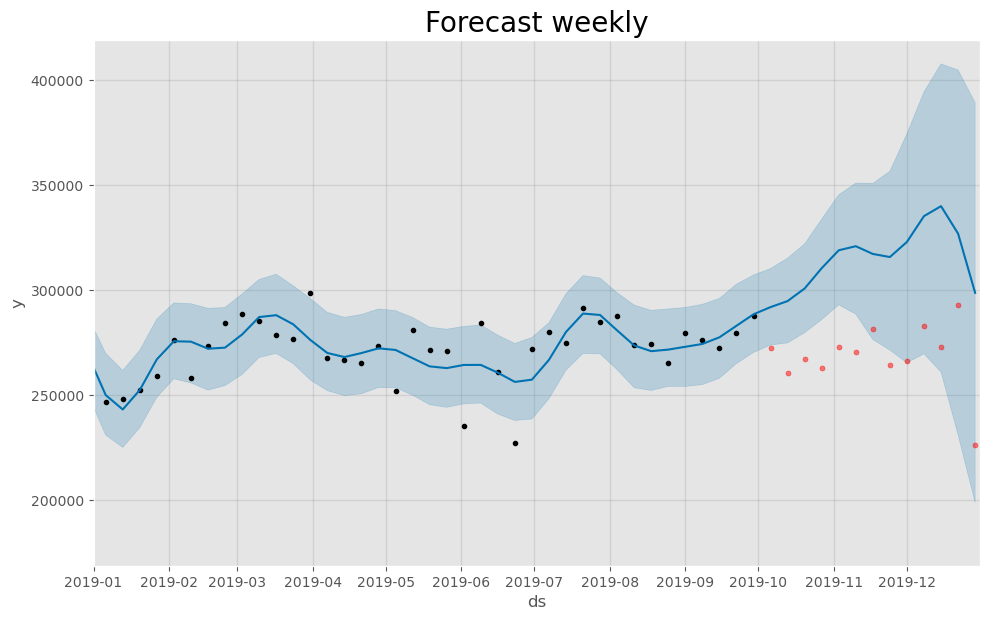

In [348]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [349]:
y_pred = forecast_semanal[['ds', 'yhat']].loc[(forecast_semanal.ds >= separacion) & (forecast_semanal.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal")
res_prophet_semanal

,Modelo,RMSE
0,Prophet Semanal,48322.126698


In [350]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
    # 'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


}



# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=True, weekly_seasonality=True).fit(prophet_fore_semanal)  # Fit model with given params
    df_cv = cross_validation(m, horizon='13 w', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B31A248790>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B32360C670>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B30FA47910>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002B3235842B0>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying 

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  34012.606139
1                     0.001                     0.10  38557.044983
2                     0.001                     1.00  38464.724097
3                     0.001                    10.00  38337.453285
4                     0.010                     0.01  33664.831511
5                     0.010                     0.10  38424.034112
6                     0.010                     1.00  38617.077844
7                     0.010                    10.00  38623.002356
8                     0.100                     0.01  29937.825599
9                     0.100                     0.10  37745.457396
10                    0.100                     1.00  38896.264893
11                    0.100                    10.00  40512.096904
12                    0.500                     0.01  29346.826235
13                    0.500                     0.10  39233.83

In [351]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [352]:
best_params = {'changepoint_prior_scale': 0.07, 'seasonality_prior_scale': 0.005}

In [353]:
prophet_semanal_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_semanal_model_op.fit(prophet_fore_semanal)
pred_prophet_semanal_op = prophet_semanal_model_op.make_future_dataframe(periods=13, freq="W" )
forecast_semanal_op = prophet_semanal_model_op.predict(pred_prophet_semanal_op)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1200x300 with 0 Axes>

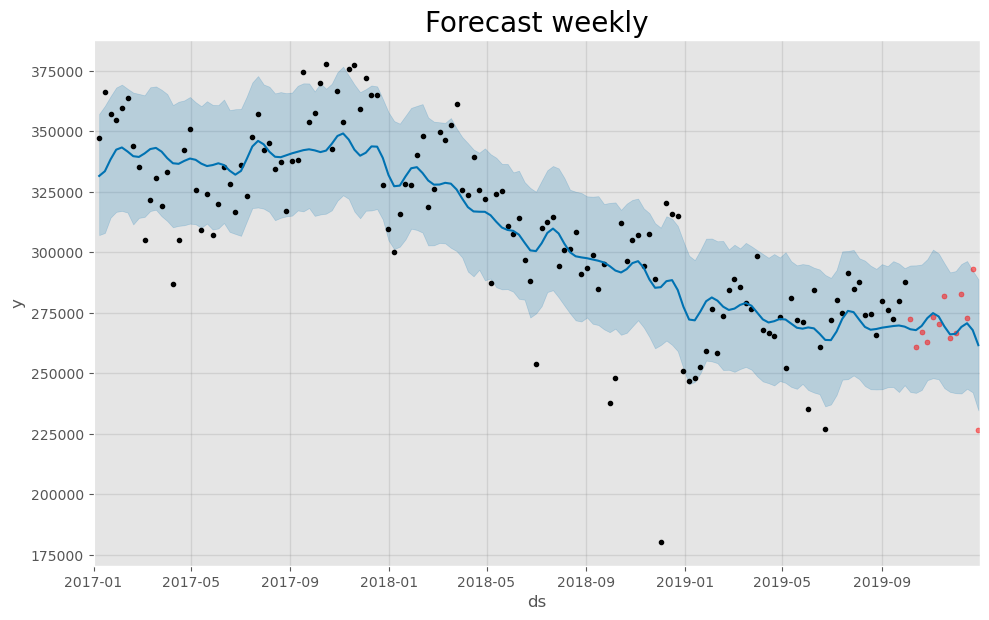

In [354]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal_op)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2017-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [355]:
y_pred = forecast_semanal_op[['ds', 'yhat']].loc[(forecast_semanal_op.ds >= separacion) & (forecast_semanal_op.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal_op = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal CV/HP")
res_prophet_semanal_op

,Modelo,RMSE
0,Prophet Semanal CV/HP,13584.016559


In [356]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        res_prophet_diario, res_prophet_diario_opt,
                        
                        autoarima_semanal_res, autosarimax_semanal_res,
                        res_prophet_semanal, res_prophet_semanal_op
                         ])

,Modelo,RMSE
0,Benchmark(diario),5948.594624
0,AutoArima-S Diario,5587.785872
0,AutoSarimax Diario,5177.831372
0,Prophet Diario,6372.959142
0,Prophet Diario CV/HP,5050.215638
0,AutoArima Semanal,20185.213058
0,AutoSarimax semanal,18428.506390
0,Prophet Semanal,48322.126698
0,Prophet Semanal CV/HP,13584.016559


Modelo Benchmark generó RMSE de 5950 pasos diarios, AutoSarimax Semanal de 18.500 y el mejor modelo Prophet Optimizado () de 5050 pasas, representando un 15% de mejora.

# Investigación

## Usar modelo generado en el año 2020

Preparamos la data 2020 para aplicarle Prophet Optimizado

In [491]:
#Importamos
data_2020 = pd.read_csv('flujo-vehicular-2020.csv')

# #Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
dataset2020 = data_2020[mask]

# # #Quitamos las columnas que no vamos a utilizar
dataset2020 = dataset2020[['fecha','cantidad_pasos','hora_fin']]

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset2020['fecha2'] = pd.to_datetime(dataset2020.fecha) + pd.to_timedelta(dataset2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset2020.sort_values('fecha', inplace = True)
dataset2020.reset_index(drop=True, inplace = True)

#Resampleamos
diario2020 = dataset2020.resample('D', on = 'fecha').sum()
diario2020.reset_index("fecha",inplace=True)
prophet_diario2020 = pd.DataFrame({'ds':diario2020.fecha, 'y':diario2020.cantidad_pasos})

prophet_diario2020

,ds,y
0,2020-01-01,21395.0
1,2020-01-02,33722.0
2,2020-01-03,37067.0
3,2020-01-04,30627.0
4,2020-01-05,27812.0
...,...,...
361,2020-12-27,8434.0
362,2020-12-28,10311.0
363,2020-12-29,12036.0
364,2020-12-30,12527.0


Recordamos el modelo

In [492]:
#Modelo
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020} #Da 5050
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_fore)

Realizamos predicción sobre 2020 y comparamos:

In [500]:
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=365)
forecast = prophet_diario_model_op.predict(prophet_diario2020)
y_pred2020 = forecast[['ds', 'yhat']]
y_true2020 = prophet_diario2020

res_prophet_diario_opt2020 = evaluar_modelo(y_pred2020['yhat'],y_true2020['y'],"Prophet Sobre 2020")
res_prophet_diario_opt2020

,Modelo,RMSE
0,Prophet Sobre 2020,23397.078482


In [544]:
prophet_diario2020

,ds,y
0,2020-01-01,21395.0
1,2020-01-02,33722.0
2,2020-01-03,37067.0
3,2020-01-04,30627.0
4,2020-01-05,27812.0
...,...,...
361,2020-12-27,8434.0
362,2020-12-28,10311.0
363,2020-12-29,12036.0
364,2020-12-30,12527.0


Como era de esperarse el año 2020 presentó un valor muy errático de 23397, influenciado evidentemente por la pandemia presentando una diferencia del más del 300%

## Agregar 2016 en el modelo y evaluar de nuevo

Importemos la data del 2016

In [551]:
#Importamos
datax_2016 = pd.read_csv('flujo-vehicular-2016.csv')
data_2016 = pd.concat([data_2019, data_2018, data_2017, datax_2016])
# data_2016 = pd.concat([data_2019, data_2018, data_2017])

# #Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2016.estacion=='Illia', data_2016.forma_pago == 'EFECTIVO')
dataset2016 = data_2016[mask]

# # #Quitamos las columnas que no vamos a utilizar
dataset2016 = dataset2016[['fecha','cantidad_pasos','hora_fin']]

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset2016['fecha2'] = pd.to_datetime(dataset2016.fecha) + pd.to_timedelta(dataset2016.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2016.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset2016.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset2016.sort_values('fecha', inplace = True)
dataset2016.reset_index(drop=True, inplace = True)

# #Resampleamos
diario2016 = dataset2016.resample('D', on = 'fecha').sum()
diario2016.reset_index("fecha",inplace=True)
prophet_diario2016 = pd.DataFrame({'ds':diario2016.fecha, 'y':diario2016.cantidad_pasos})

prophet_diario2016_train = prophet_diario2016.iloc[:-92,:]
print('Train', prophet_diario2016_train.shape)
prophet_diario2016_test = prophet_diario2016.iloc[-92:,:]
print('Test', prophet_diario2016_test.shape)

Train (1369, 2)
Test (92, 2)


Entrenemos el modelo con la nueva data

In [556]:
#Modelo
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020} #Da 5050
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_diario2016_train)

Evaluemos RMSE sobre los mismos tres meses

In [557]:
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=92)
forecast = prophet_diario_model_op.predict(prophet_diario2016_test)
y_pred2016 = forecast[['ds', 'yhat']]
y_true2016 = diario_datos_test[['ds', 'y']]

res_prophet_diario_opt2016 = evaluar_modelo(y_pred2016['yhat'],y_true2016['y'],"Prophet Sobre con 2016")
res_prophet_diario_opt2016

,Modelo,RMSE
0,Prophet Sobre con 2016,5463.357546


El modelo aumentó el RMSE de 5050 hasta 5463 aumentando un 8%. Puede que el ultimo trimestre que se evalua no se represantativo de los años anteriores ya que puede que este afectado por la pandemia, ademas en la exploración de la data se pudo observar que este año fue un poco inusual con respecto a 2018 y 2017

# CONCLUSIONES

-El Proyecto se basó en estudiar el paso vehicular en la ciudad de Buenos Aires, específicamente en la autopista Illia con pago sólo en efectivo.\
-La data utilizada fue la correspondiente a los años 2017, 2018 y 2019.\
-No se observó valores nulos en la data de los tres años. Por otro lado, se observaron outliers con pasos vehiculares muy bajos que se pudieron explicar con eventos sociales conocidos.\
-Años 2017 y 2018 con 1.3 millones de pasos, 2019 con 800 mil, 40 % menos. Probablemente afectado por el inicio de la pandemia. Además, se observan distribuciones de pasos hacia la derecha, es decir con mas tendencia a aumentar la cantidad de pasos.\
-Estación con más flujo: Avellaneda\
-33% más de flujo hacia provincia que hacia centro. Probablemente hacia centro haya vías alternas que sean tomadas.\
-Entre un 20 y 30 % más de vehículos pesados que livianos. Sin embargo, esto cambio drásticamente el año 2016, siendo mucho menor e inverso.\
-La descomposición de la serie demostró tendencia a la disminución de pasos. La tendencia lineal da indicios que se puede tratar como un modelo de adición.  Además, como era de esperarse se observa fuerte estacionalidad semanal. El ruido muestra que probablemente hayan otras estacionalidades que no se han considerado.\
-Según la prueba de ADFuller, no hay razón para rechazar la hipótesis nula. Por lo que la serie es de hecho No-Estacionaria.\
-Los modelos fueron evaluados con dataset diario y semanal.\
-Modelo Benchmark generó RMSE de 5950 pasos diarios, AutoSarimax Semanal de 18.500 y el mejor modelo Prophet Optimizado changepoint_prior_scale: 0.007, seasonality_prior_scale: 0.020) de 5050 pasas, representando un 15% de mejora.\
-Como era de esperarse el año 2020 presentó un valor muy errático de 23397, influenciado evidentemente por la pandemia presentando una diferencia del más del 300%\
-Cuando se incorporó la data del 2016, el modelo aumentó el RMSE de 5050 hasta 5463 aumentando un 8%. Puede que el último trimestre que se evalua no se represantativo de los años anteriores ya que puede que este afectado por la pandemia, ademas en la exploración de la data se pudo observar que este año fue un poco inusual con respecto a 2018 y 2017
